# V4 Neural Data Challenge

$\hspace{3mm}$ Understanding the tuning of neurons in the visual system is one of the most daunting problems in systems neuroscience. While much headway has been made since Hubel and Wiesel's seminal paper in 1962, understanding the neural code underlying object recognition has remained elusive. Key to understanding how our brain transforms single photons into robust representations of objects is exploring the selectivity of intermediate areas in the ventral visual pathway. Here, we seek to understand the responses of neurons in extrastriate visual area V4.

$\hspace{3mm}$To begin, we extracted several basic features which we thought could explain neural responses to some degree. We started by using the raw RGB values, the pixel values in LAB space (an alternate color space), the power spectrum of the 2D fourier transform, the components of a discrete wavelet transformation of the image (using a Gabor filter), and finally several basic image statistics. These statistics are calculated only on the center of the image. They are: the minimum pixel value, the maximum pixel value, the mean pixel value, and the standard deviation of the pixel values. These were computed for each channel (RGB). <br><br>
$\hspace{3mm}$ We also included the output of Alexnet as features to regress upon. Briefly, we normalized and rescaled the images, ran them through Alexnet, and got the response of all 5 convolutional layers. We only used the responses to the center of the image (e.g., conv1 is 55 x 55 x 196, we only use the middle 20 x 20 x 196 block of responses). 

The code to compute the basic image features can be found at: <br>
https://github.com/lambdaloop/v4-challenge/blob/master/compute_features.py

The code to compute the Alexnet features can be found at: <br>
https://github.com/lambdaloop/v4-challenge/blob/master/notebooks/nn_output_aspredictor.ipynb

In [1]:
import pandas as pd
import numpy as np
from scipy import stats, signal
from tqdm import trange, tqdm
from matplotlib.pyplot import *

%matplotlib inline

In [2]:
# Machine learning stuff
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics.scorer import make_scorer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor


import umap

/home/pierre/.local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# figure styling
import seaborn as sns
sns.set(style='ticks', palette='colorblind')

rcParams['figure.figsize'] = (13,4.5)
rcParams['figure.dpi'] = 200

In [4]:
images = np.load('../data/stim.npy')

train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/sub.csv')

responses = np.array(train.iloc[:, 1:])

dd = np.load('../data/features.npz')
features = dict()
for k in dd.keys():
    features[k] = dd[k]

    
conv_train = np.load('../data/conv_train.npy').flat[0]
conv_test = np.load('../data/conv_test.npy').flat[0]

conv_features = dict()
for k in conv_train.keys():
    conv_features[k] = np.vstack([conv_test[k], conv_train[k]])

In [5]:
features.keys()

dict_keys(['raw', 'LAB', 'edges', 'fourier', 'gabor', 'stats', 'stats_LAB', 'stats_HSV', 'stats_edges'])

In [6]:
conv_features.keys()

dict_keys(['conv1', 'conv2', 'conv3', 'conv4', 'conv5'])

# Visualizing neuron responses
Below is the square root of the mean response of all neurons to all images. The colorbar on the right shows the scale. Neurons with such low responses, like neuron 17 in the above plot, proved very difficult/impossible to fit. 

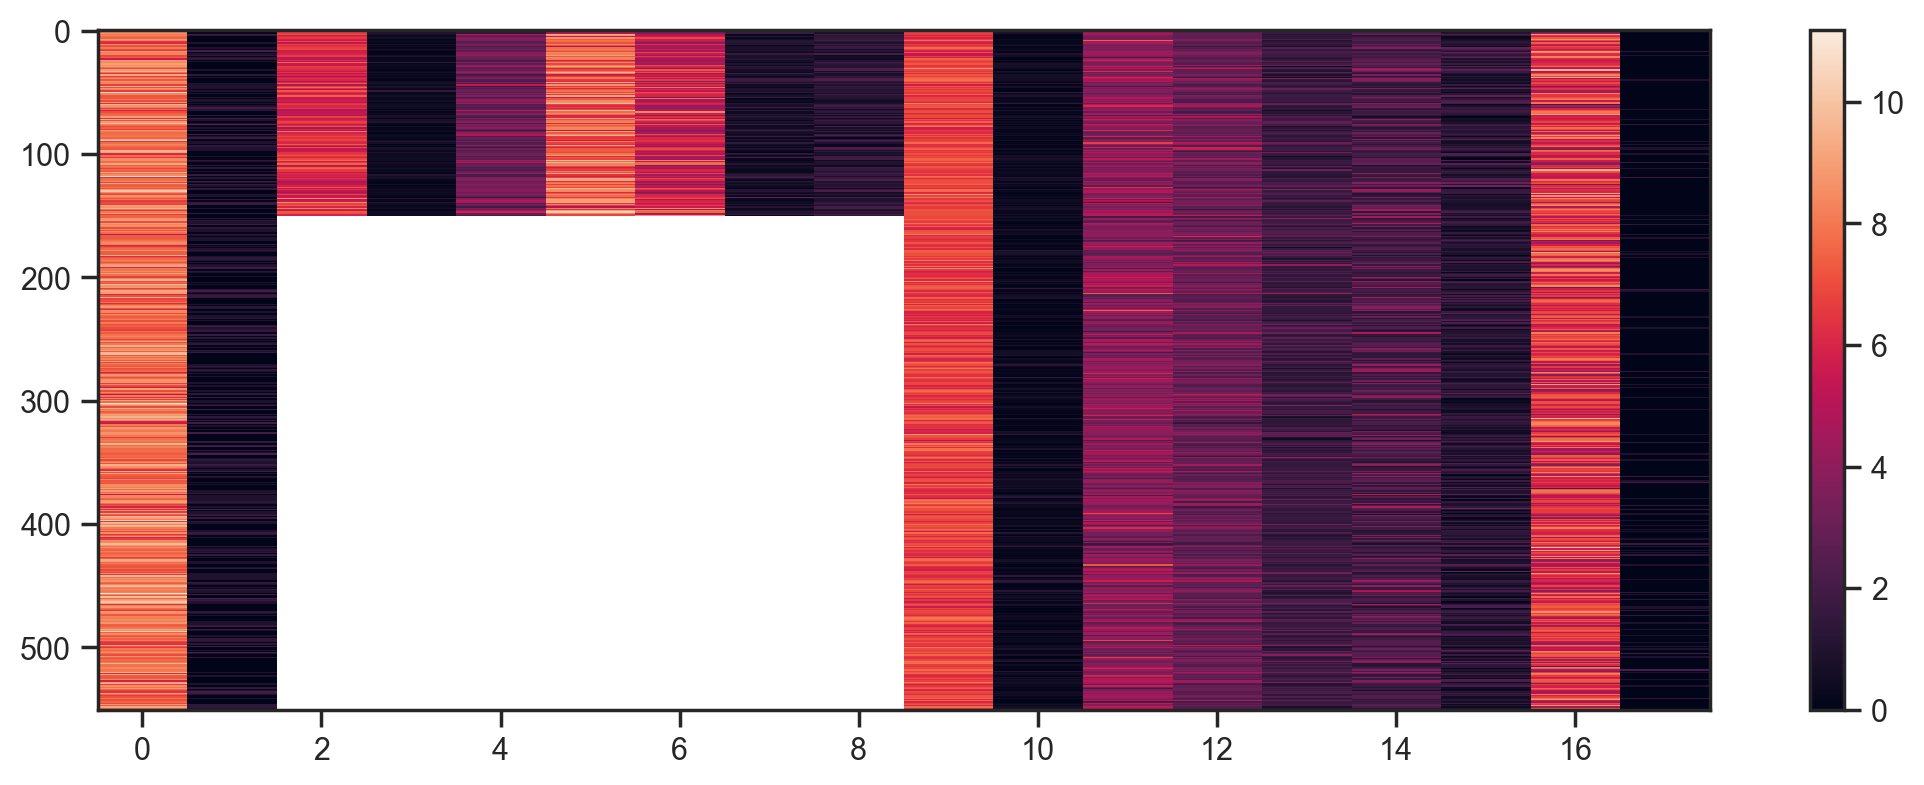

In [7]:

imshow(responses, aspect='auto')
colorbar()

## Imputing responses
In order make sense of the responses further, we standardize each neuron's responses by subtracting the median and dividing by the standard deviation. Furthermore, we impute the responses of neurons 2-8 so that we can cluster them.

Using TensorFlow backend.


Limited tf.compat.v2.summary API due to missing TensorBoard installation
Imputing row 1/551 with 0 missing, elapsed time: 0.055
Imputing row 101/551 with 0 missing, elapsed time: 0.055
Imputing row 201/551 with 7 missing, elapsed time: 0.060
Imputing row 301/551 with 7 missing, elapsed time: 0.070
Imputing row 401/551 with 7 missing, elapsed time: 0.081
Imputing row 501/551 with 7 missing, elapsed time: 0.094


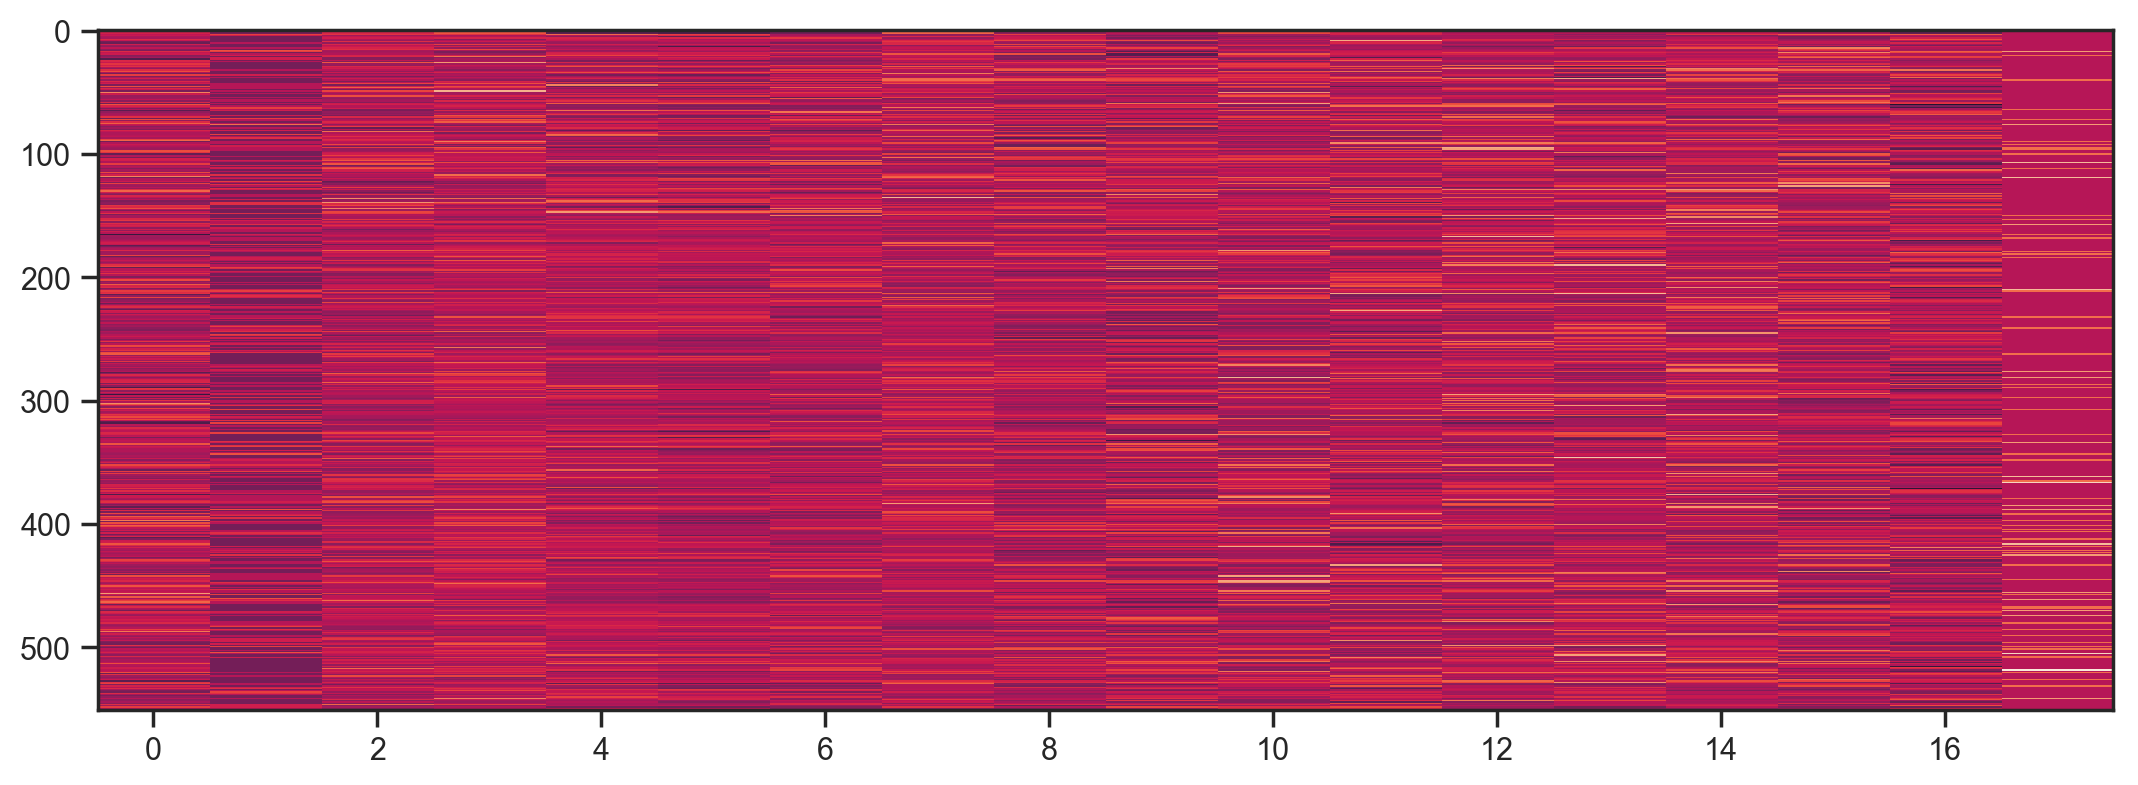

In [8]:
responses_demean = np.copy(responses)
responses_std = np.copy(responses)

for r in range(responses.shape[1]):
    vals = responses[:,r]
    vs = vals[~np.isnan(vals)]
    responses_demean[:,r] = vals-np.median(vs)
    responses_std[:,r] = (vals-np.median(vs))/np.std(vs)
    
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler

responses_imputed = KNN(k=2).fit_transform(responses_std)
#responses_imputed = SoftImpute().fit_transform(responses_std)

imshow(responses_imputed, aspect='auto')

## Clustering neurons and features

To better understand why we could explain the responses of some neurons and not others, we then clustered the neurons by imputed normalized responses (the x axis represents neuron, the y axis represents image). As one might expect, the pairs of neurons (2 & 3, 4 & 5, 7 & 8) which were recorded on the same date clustered. Besides this, it is hard to make sense of the clusters, except for noting there seem to be about 5 main groups.

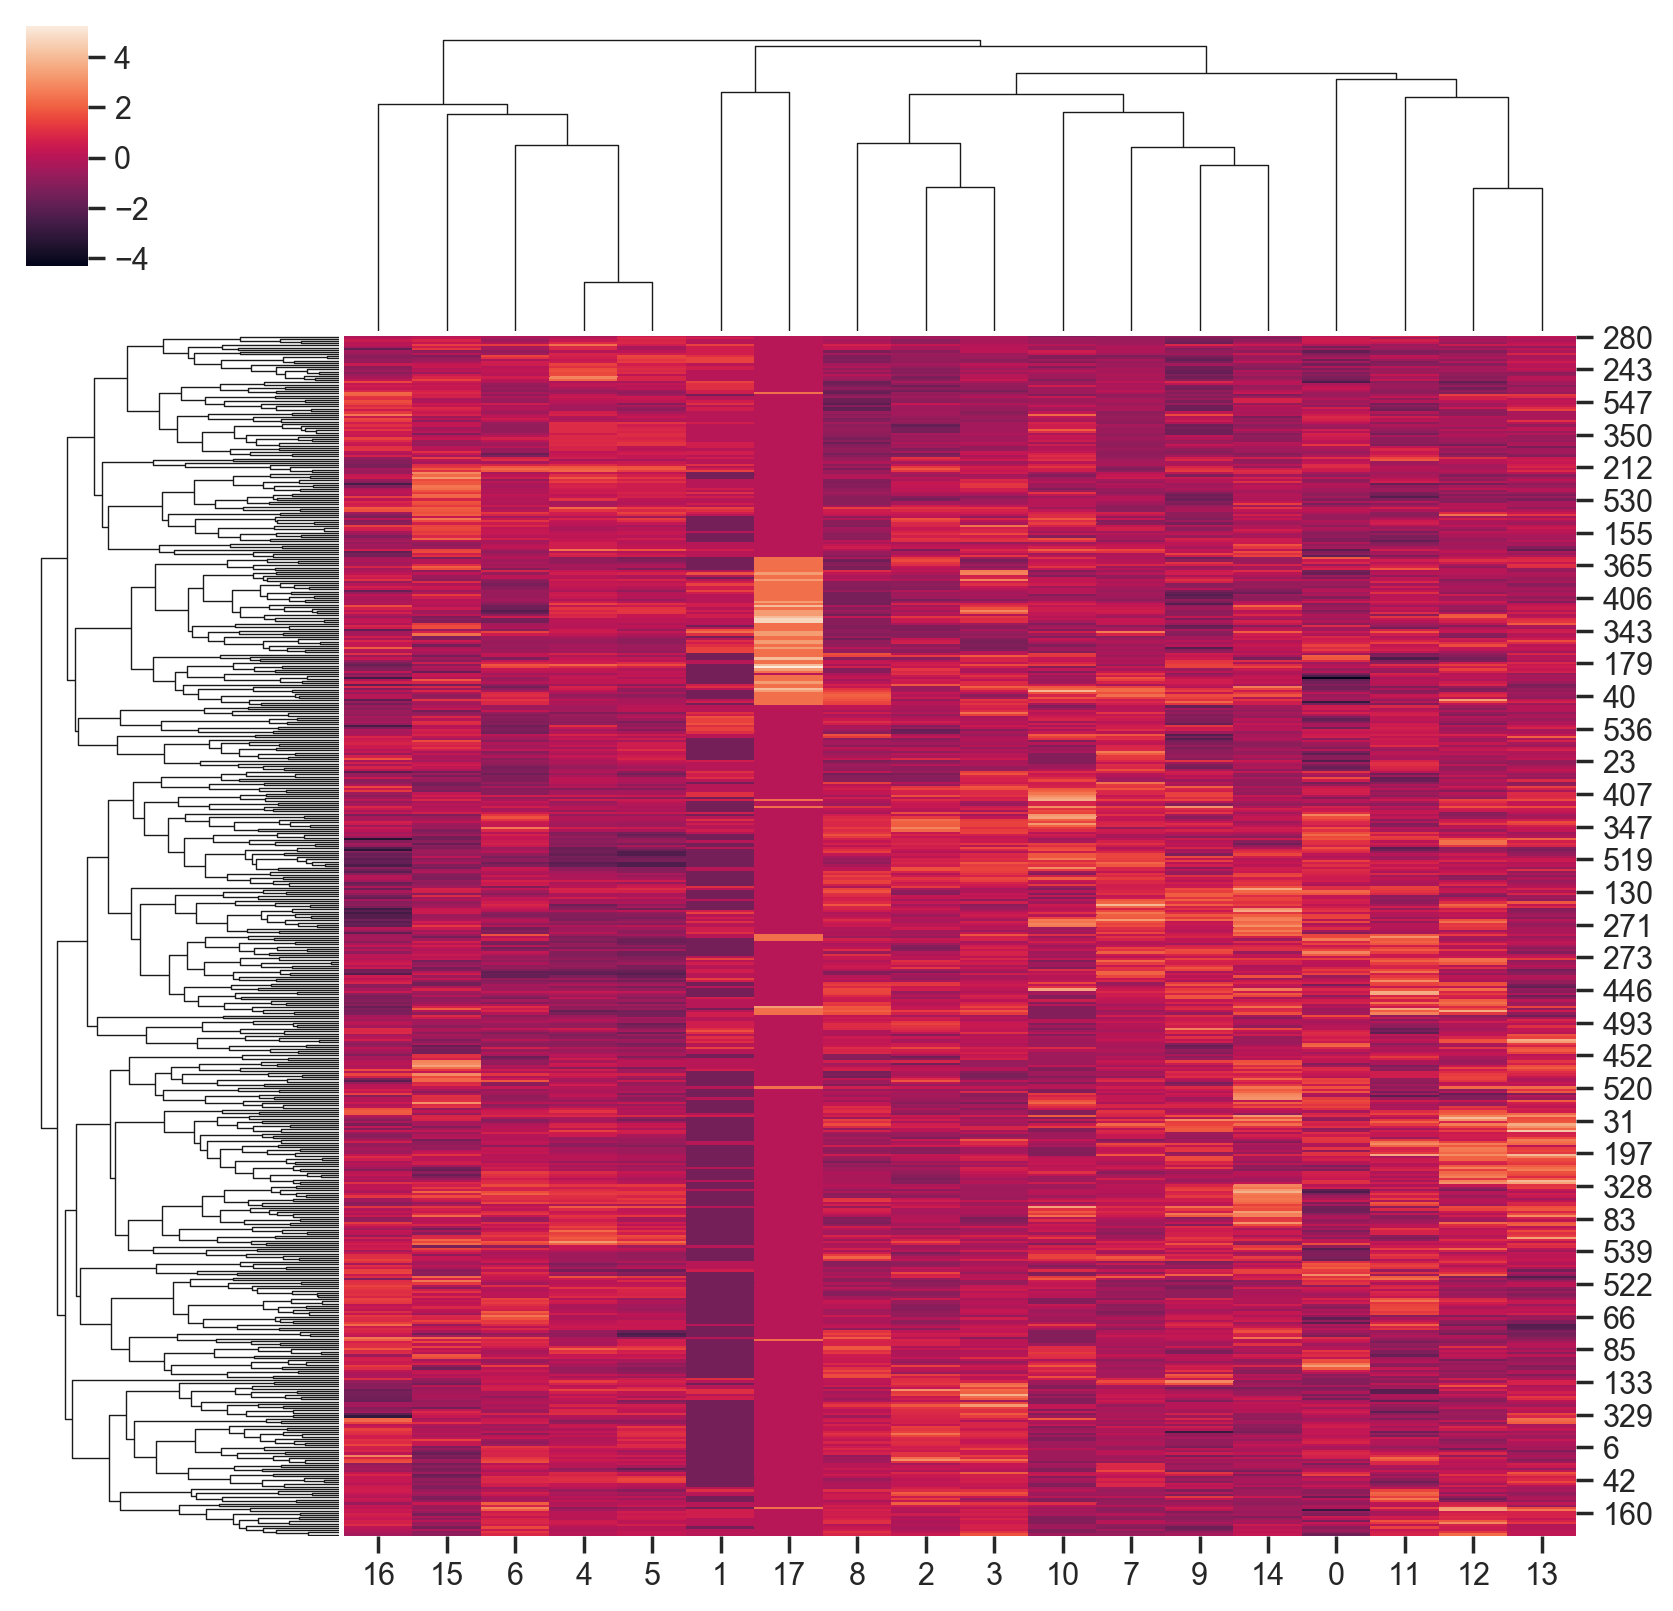

In [9]:
sns.clustermap(responses_imputed, metric='correlation')

## Preprocessing and choosing features

In the following section, we preprocess all the features in order to feed them our regressor.

We found that any fitting algorithm performed poorly with too many predictors, so we projected each feature with too many predictors onto its principal components. 

In addition, we also suspected that the visual system may be responding to the position of images on a manifold. In order to get at this manifold, we also computed a projection using the [UMAP](https://github.com/lmcinnes/umap) embedding. 

The number of components for both PCA and UMAP was optimized manually to minimize the cross-validated mean rmse. It is likely that optimizing these parameters with a proper search could lead to a better solution.


In [10]:
pcs_lab = PCA(n_components=50).fit_transform(features['LAB'])
pcs_fourier = PCA(n_components=30).fit_transform(features['fourier'])
pcs_gabor = PCA(n_components=20).fit_transform(features['gabor'])

In [11]:
pcs_raw = PCA(n_components=20).fit_transform(features['raw'])
pcs_edges = PCA(n_components=20).fit_transform(features['edges'])

In [12]:
pcs_conv1 = PCA(n_components=30).fit_transform(conv_features['conv1'])
pcs_conv2 = PCA(n_components=20).fit_transform(conv_features['conv2'])
pcs_conv3 = PCA(n_components=20).fit_transform(conv_features['conv3'])
pcs_conv4 = PCA(n_components=20).fit_transform(conv_features['conv4'])
pcs_conv5 = PCA(n_components=20).fit_transform(conv_features['conv5'])

In [13]:
embedding = umap.UMAP(metric='correlation', min_dist=1.0, n_components=100)
X_embed = embedding.fit_transform(features['raw'])

In [14]:
embedding = umap.UMAP(metric='correlation', min_dist=1.0, n_components=10)
X_embed_edges = embedding.fit_transform(features['edges'])

embedding = umap.UMAP(metric='correlation', min_dist=1.0, n_components=10)
X_embed_fourier = embedding.fit_transform(features['fourier'])

embedding = umap.UMAP(metric='correlation', min_dist=1.0, n_components=10)
X_embed_lab = embedding.fit_transform(features['LAB'])

In [15]:
X_all = np.hstack([
   X_embed,  
   X_embed_edges,
   X_embed_lab, 
   X_embed_fourier,
   features['stats'], 
   features['stats_LAB'], 
   features['stats_edges'],
   pcs_lab,
   pcs_fourier, 
   pcs_gabor,
   pcs_edges,
   pcs_raw,
   pcs_conv1, 
   pcs_conv2, 
   pcs_conv3,
   pcs_conv4,  
   pcs_conv5,
                  ])

X_all.shape

(601, 470)

In [16]:
def make_names_vec(X, prefix):
    return ['{}_{}'.format(prefix, i) for i in range(X.shape[1])]

In [17]:
stat_names = ['min', 'max', 'rms', 'mean', 'std'] + ['moment_' + str(i) for i in range(3,8)]
stat_feature_names = ['{}_{}'.format(s, x) for x in ['r','g','b'] for s in stat_names ]
stat_lab_names = ['{}_{}'.format(s, x) for x in ['L', 'La', 'Lb'] for s in stat_names]
stat_edge_names = ['{}_{}'.format(s, x) for x in ['r_edge', 'g_edge', 'b_edge'] for s in stat_names]

names = np.hstack([
    make_names_vec(X_embed, 'UMAP_raw'),
    make_names_vec(X_embed_edges, 'UMAP_edges'),
    make_names_vec(X_embed_lab, 'UMAP_LAB'),
    make_names_vec(X_embed_fourier, 'UMAP_fourier'),
    stat_feature_names,
    stat_lab_names,
    stat_edge_names,
    make_names_vec(pcs_lab, 'PC_LAB'),
    make_names_vec(pcs_fourier, 'PC_fourier'),
    make_names_vec(pcs_gabor, 'PC_gabor'),
    make_names_vec(pcs_edges, 'PC_edges'),
    make_names_vec(pcs_raw, 'PC_raw'),
    make_names_vec(pcs_conv1, 'PC_conv1'),
    make_names_vec(pcs_conv2, 'PC_conv2'),
    make_names_vec(pcs_conv3, 'PC_conv3'),
    make_names_vec(pcs_conv4, 'PC_conv4'),
    make_names_vec(pcs_conv5, 'PC_conv5')
])

len(names)


470

# Analysis of fits

Next, we take all the features and fit the model neuron by neuron. 
We played around with a couple models in scikit-learn, and found the extra-trees regressor to perform the best. This estimator averages a bunch of decision trees fit on the sub-samples of the data. This allows the model to fit nonlinearities and interactions but controlling for overfitting. 

One interesting attribute of the decision tree-based models is that we can obtain the "importance" of each feature to the model. This is a value which quantifies how well the feature tends to split the data on average. The sum of importances over all features for each model is 1.

In the following section, we will explore what our model may be explaining in each of the neurons, and thus try to make sense of the variety of neurons present in V4.

In [18]:
# model = ExtraTreesRegressor(max_depth=None, max_features='sqrt', criterion="mse", n_estimators=100, n_jobs=1)
model = ExtraTreesRegressor(max_depth=None, criterion="mse", n_estimators=400, n_jobs=4)

importances = []

for i in trange(responses.shape[1]):
    vals = responses[:, i]
    good = ~np.isnan(vals)
    model.fit(X_all[50:][good], vals[good])
    importances.append(model.feature_importances_)
    
importances = np.array(importances)

100%|██████████| 18/18 [01:22<00:00,  4.60s/it]


## Visualizing importances

In the cell below, we visualize the importances of the top 80% features, through clustering. Based on the features they respond to, there appear to be different types of neurons. We enumerate the classes we found below, along with a higher order description of the features:

- Neurons 2, 12, 13: edges and some gabor patches, possibly textures as captured by AlexNet features
- Neurons 0, 8, 9: third central moment (the skewness) of color and luminosity
- Neurons 4, 5, 11, 15: higher order features of the images, as captured by the UMAP manifold
- Neurons 3, 7, 14, 16: general luminosity of the image
- Neurons 1, 6: amount of a certain color in the image

It is unclear from the pattern of importances what neurons 10 and 17 respond to. Note that our fits for these neurons were worse than others, so these may just be inherently noiser or may not be responding to visual features that we are modeling.

In [19]:

## pick out the top 80% features for visualization
summed = np.sum(importances, axis=0)
good_features = summed > np.percentile(summed, 80)
print(np.sum(good_features))

importances_crop = importances[:,good_features]
names_crop = names[good_features]


94


''

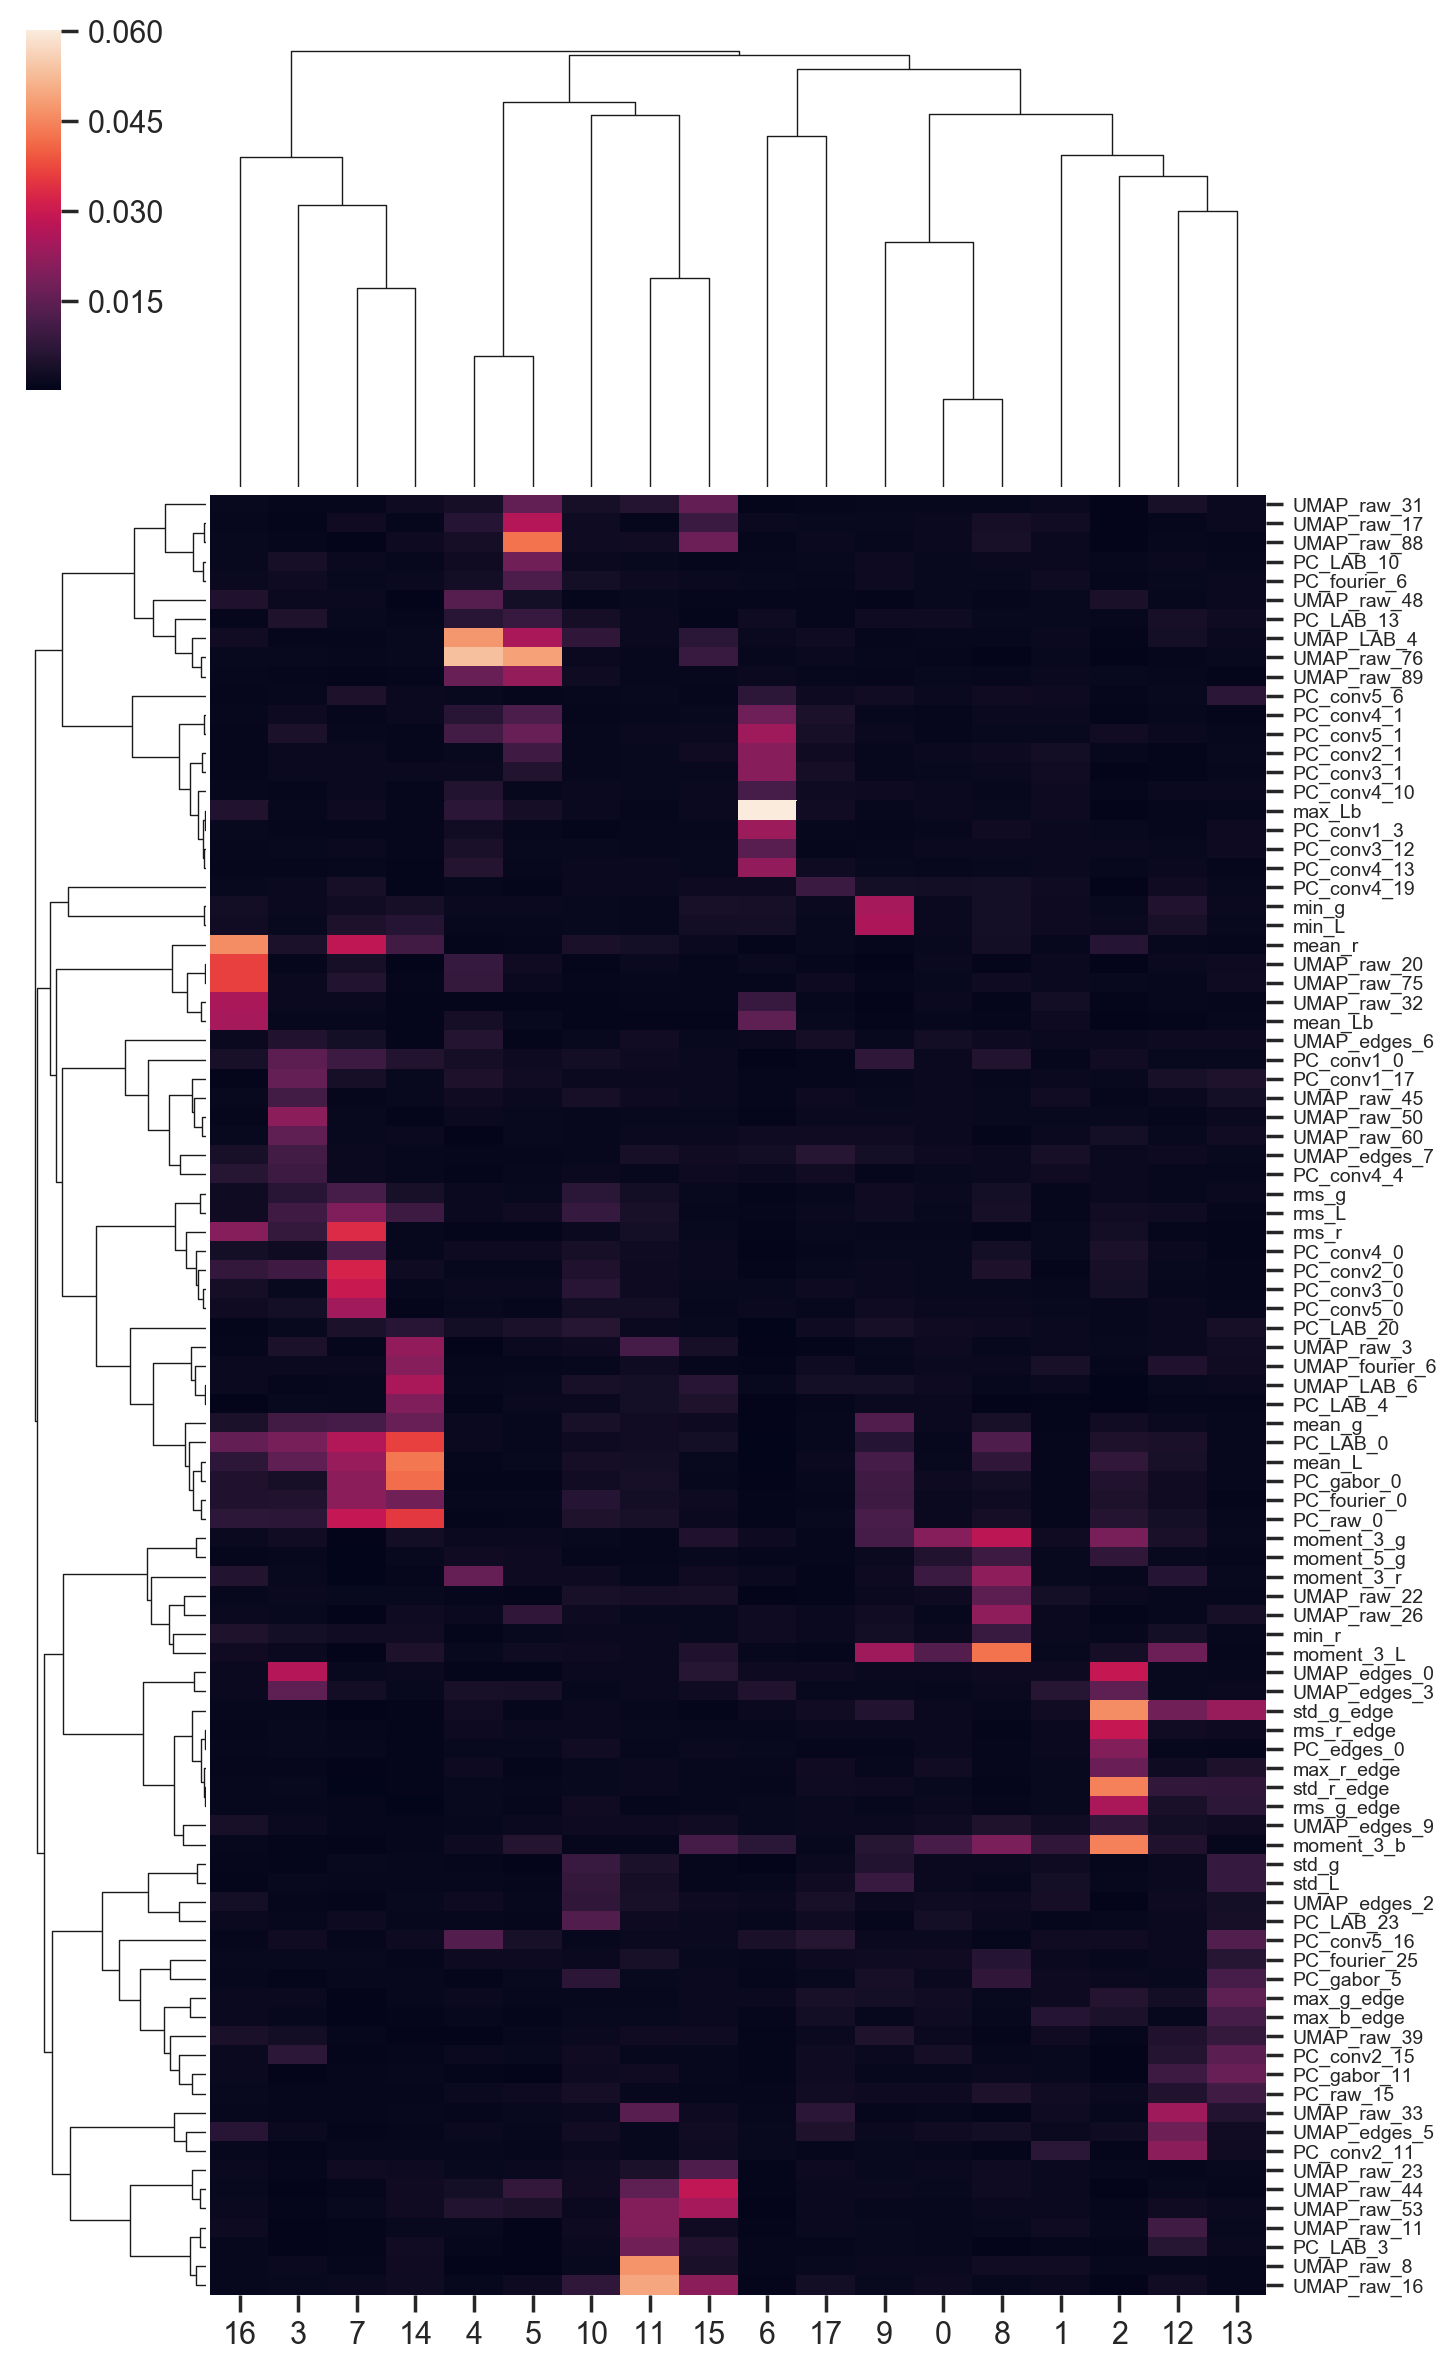

In [20]:
df = pd.DataFrame(importances_crop, columns=names_crop)

g = sns.clustermap(df.T, yticklabels=1, figsize=(8,15), metric='correlation')
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=7)
''

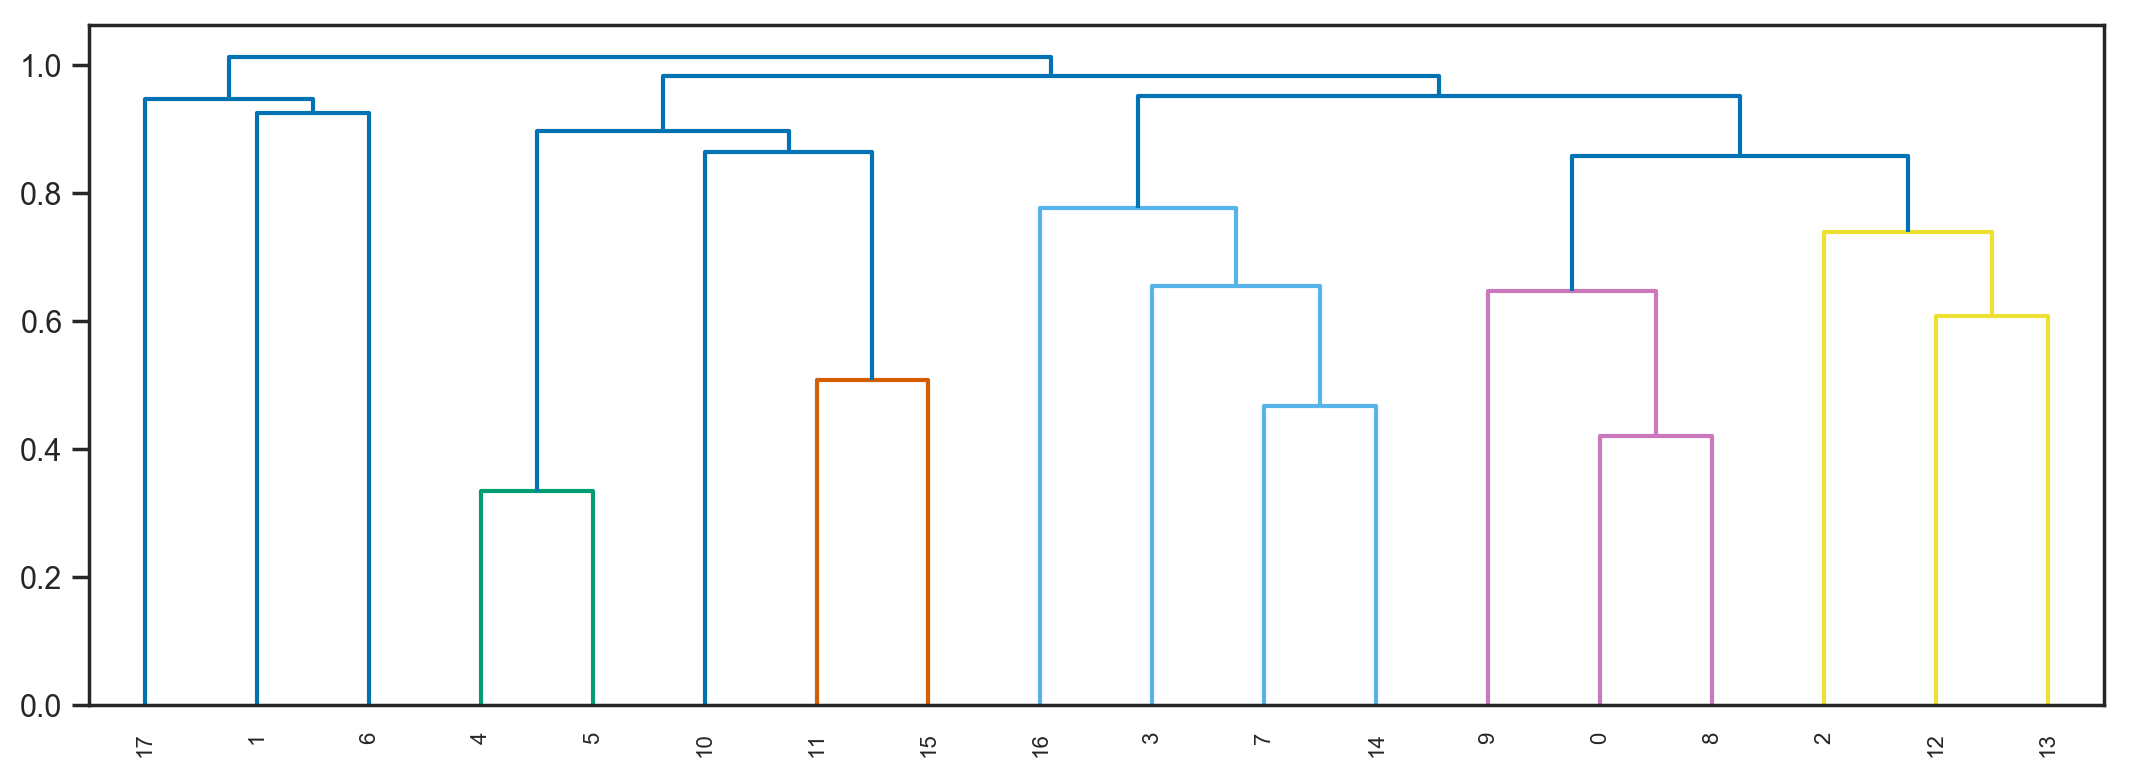

In [21]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster


Z = linkage(importances, 'weighted', 'correlation')

t = 0.8*np.max(Z[:,2])

_ = dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    color_threshold=t
)

clusters = fcluster(Z, t, criterion='distance')

In [22]:
np.unique(clusters)

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [23]:
for c in np.unique(clusters):
    check = np.where(clusters == c)[0]
    print('cluster {}'.format(c))
    for i in check:
        top = np.argsort(-importances[i])[:4]
        print(i, '\t',', '.join(names[top]))

cluster 1
1 	 UMAP_raw_62, UMAP_raw_46, moment_3_b, UMAP_raw_59
cluster 2
6 	 max_Lb, PC_conv5_1, PC_conv1_3, PC_conv4_13
cluster 3
17 	 UMAP_fourier_4, PC_fourier_20, PC_LAB_43, PC_conv4_19
cluster 4
4 	 UMAP_raw_76, UMAP_LAB_4, UMAP_raw_89, moment_3_r
5 	 UMAP_raw_76, UMAP_raw_88, UMAP_raw_17, UMAP_LAB_4
cluster 5
11 	 UMAP_raw_16, UMAP_raw_8, UMAP_raw_53, UMAP_raw_11
15 	 UMAP_raw_44, UMAP_raw_53, UMAP_raw_16, UMAP_raw_88
cluster 6
10 	 PC_LAB_23, std_g, rms_L, PC_edges_18
cluster 7
3 	 UMAP_edges_0, UMAP_raw_50, PC_LAB_0, PC_conv1_17
7 	 rms_r, PC_conv2_0, PC_conv3_0, PC_raw_0
14 	 mean_L, PC_gabor_0, PC_LAB_0, PC_raw_0
16 	 mean_r, UMAP_raw_75, UMAP_raw_20, UMAP_raw_32
cluster 8
0 	 moment_3_g, moment_3_L, moment_3_b, UMAP_raw_29
8 	 moment_3_L, moment_3_g, UMAP_raw_26, moment_3_r
9 	 min_L, min_g, moment_3_L, mean_g
cluster 9
2 	 std_g_edge, std_r_edge, moment_3_b, rms_r_edge
12 	 UMAP_raw_33, PC_conv2_11, std_g_edge, UMAP_edges_5
13 	 std_g_edge, PC_gabor_11, max_g_edge, PC_conv

## Visualizing clusters

Finally, we conclude by visualizing examples of images with each particular feature, in order to get an intuition for each cluster. For each cluster and for each neuron, we plot a visualization of the most important features.

The visualization shows the top 10 images with the highest value of that feature, and the bottom 10. 

In [24]:
def get_mega_image(images, ncols=5):
    rows = []
    row = []
    for i, im in enumerate(images):
        row.append(im[20:-20, 20:-20])
        if (i+1) % ncols == 0:
            rows.append(np.hstack(row))
            row = []
    if len(row) > 0:
        black = np.zeros(row[0].shape)
        while len(row) < ncols:
            row.append(black)
        rows.append(np.hstack(row))
    im = np.vstack(rows)
    return im

def visualize_images(images, ncols=5):
    im = get_mega_image(images, ncols)
    imshow(im)
    axis('off')
    
def visualize_feature_maxmin(images, feature, samples=10):
    high = np.argsort(-feature)[:samples]
    low = np.argsort(feature)[:samples]
    ims = np.vstack([images[high], images[low]])
    visualize_images(ims, ncols=samples)
    
def visualize_feature_gradation(images, feature, samples=10):
    high = np.argsort(feature)
    high = high[::len(high)//(samples-1)]
    ims = images[high]
    visualize_images(ims, ncols=samples)

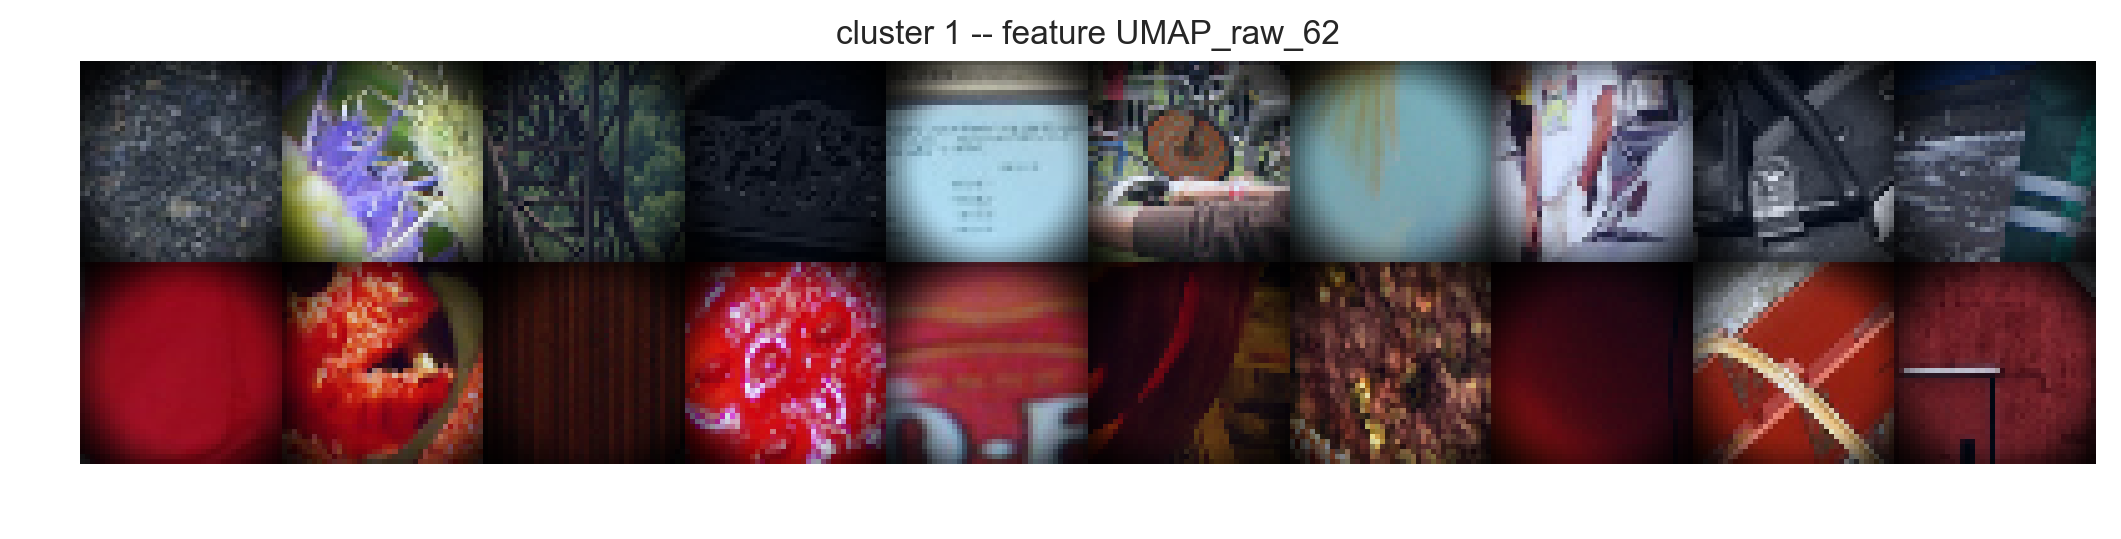

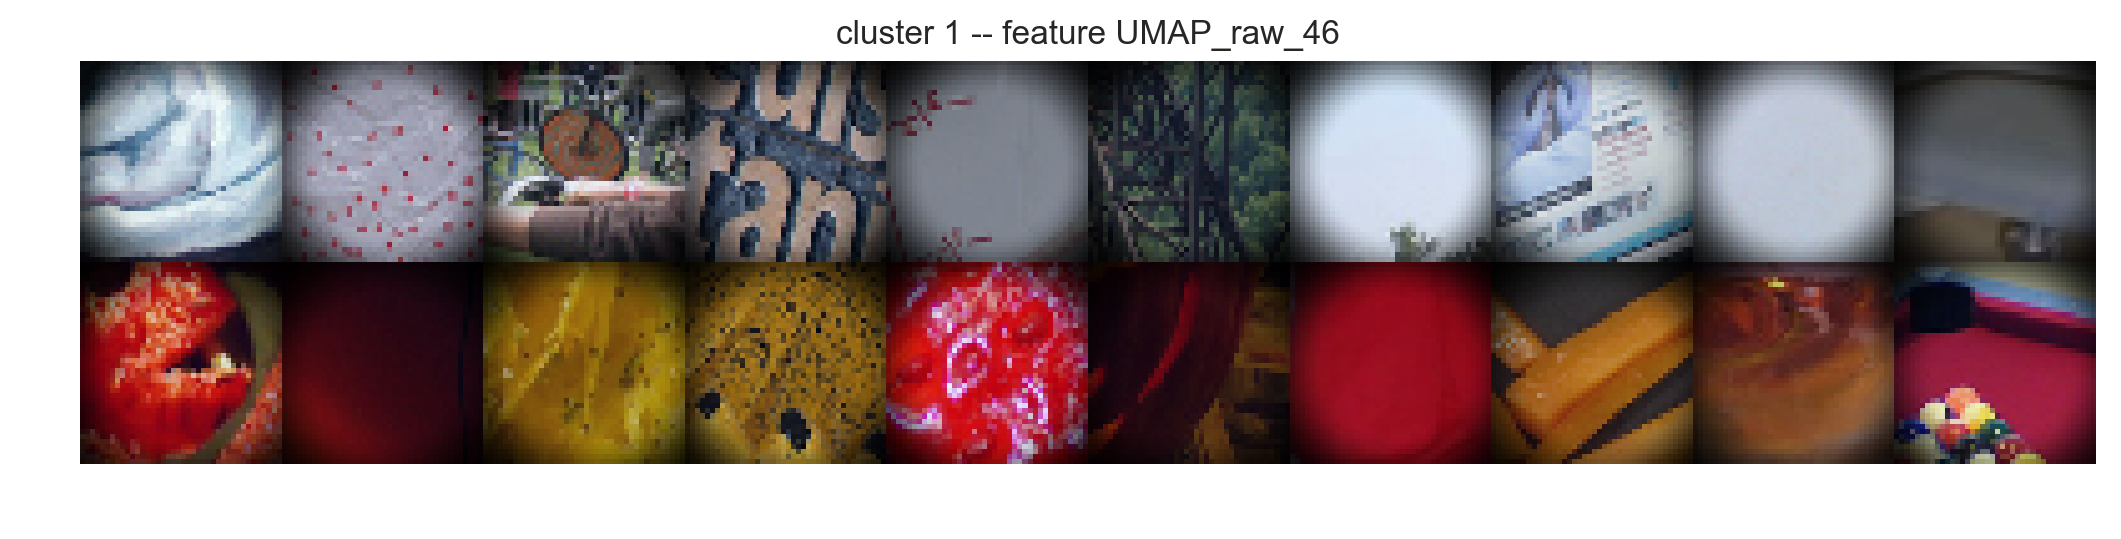

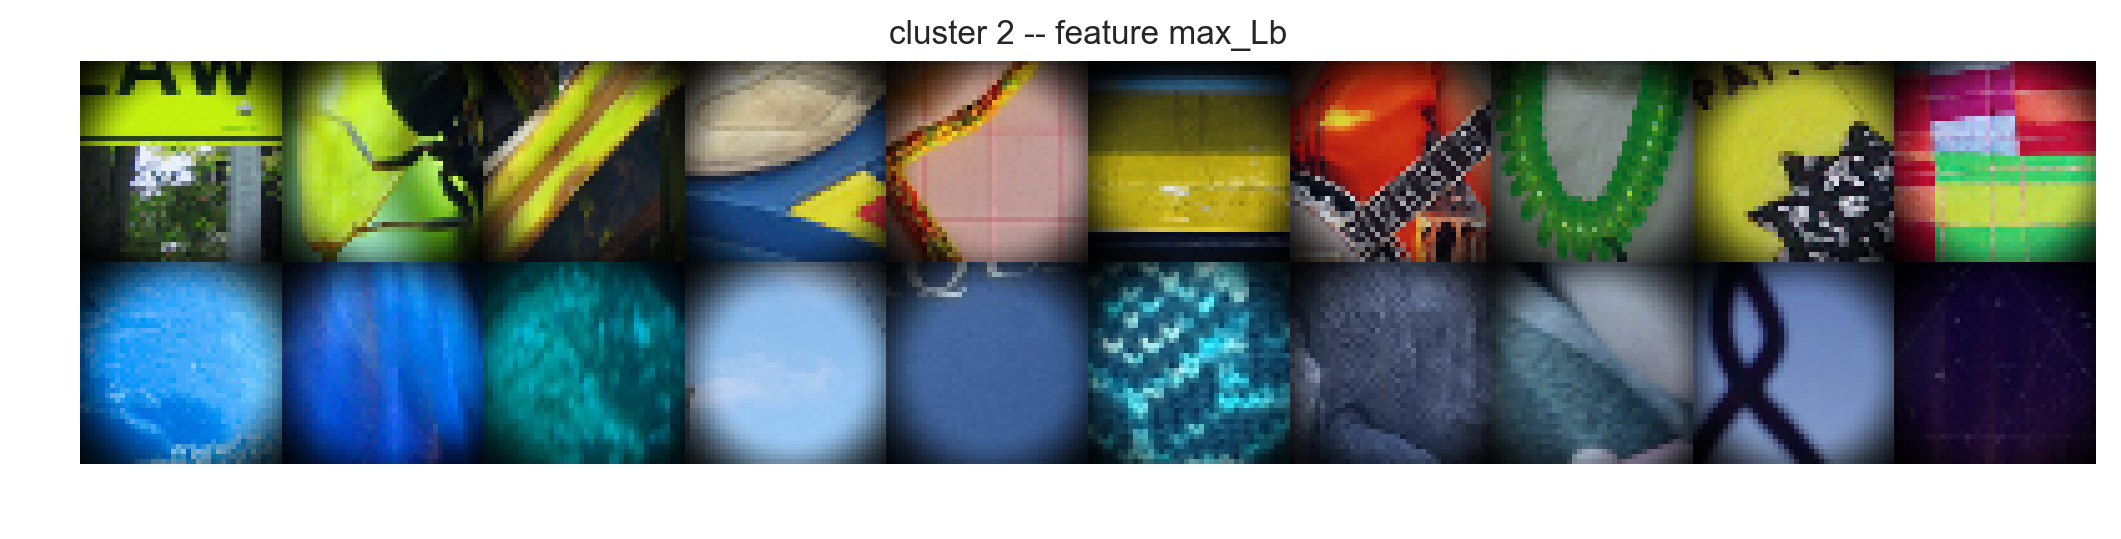

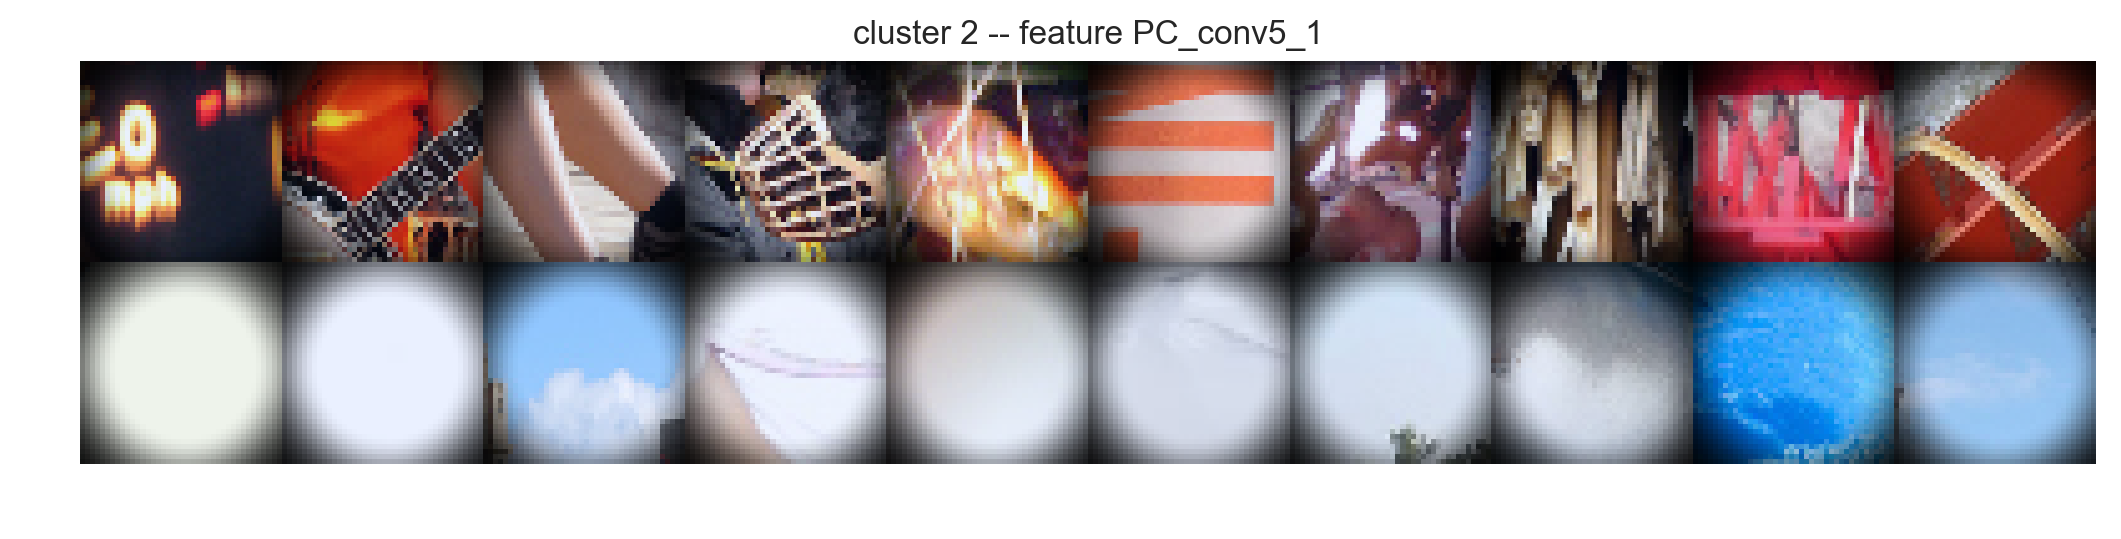

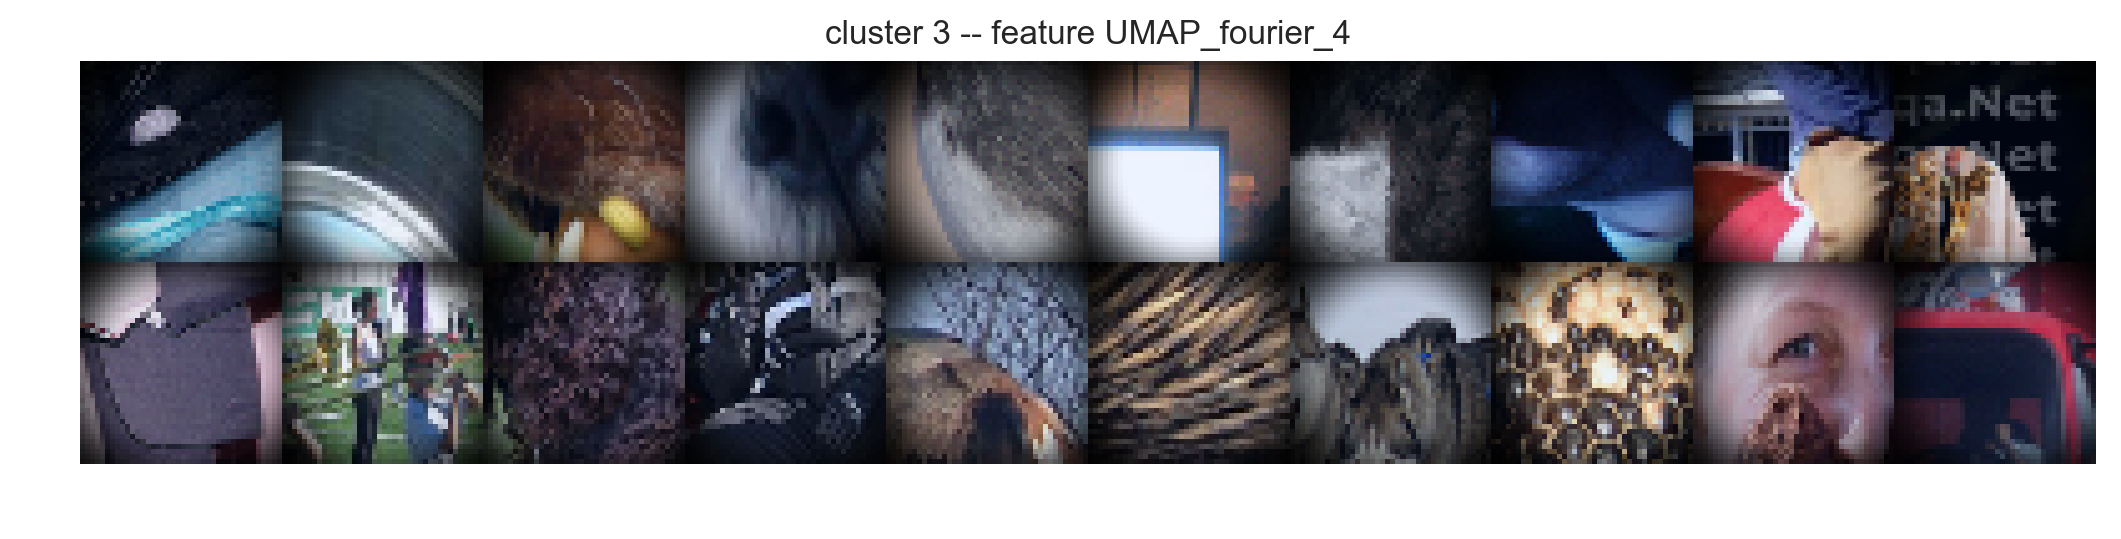

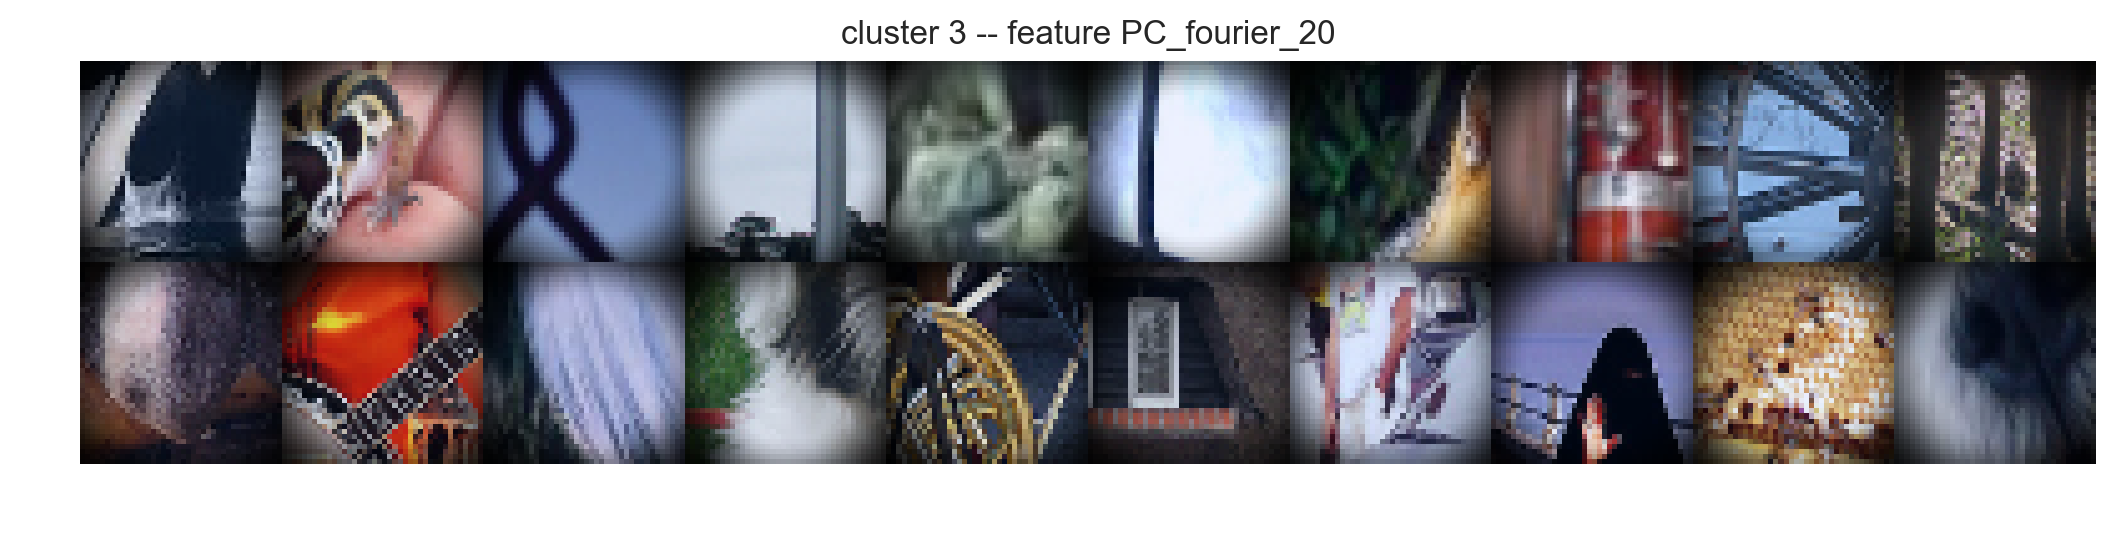

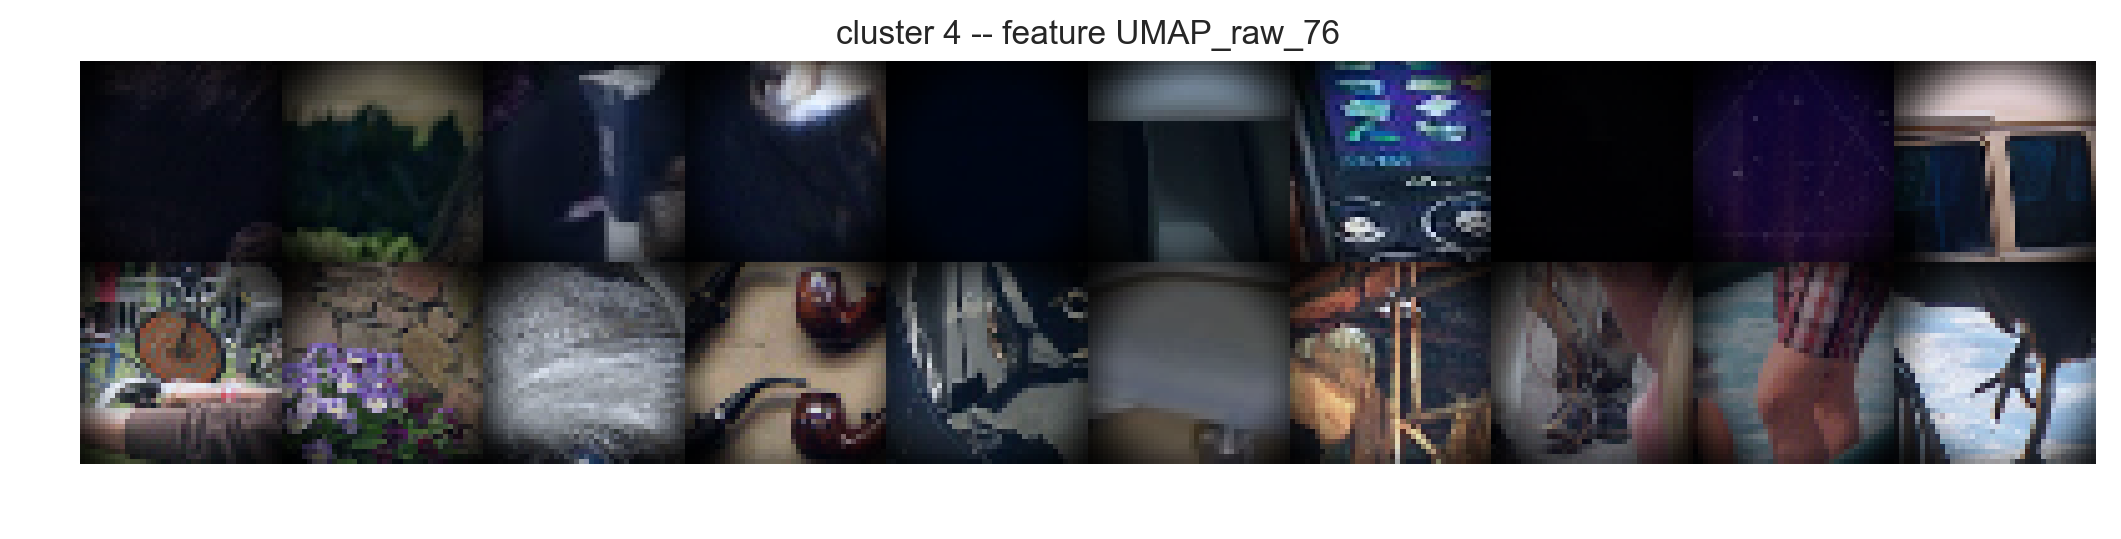

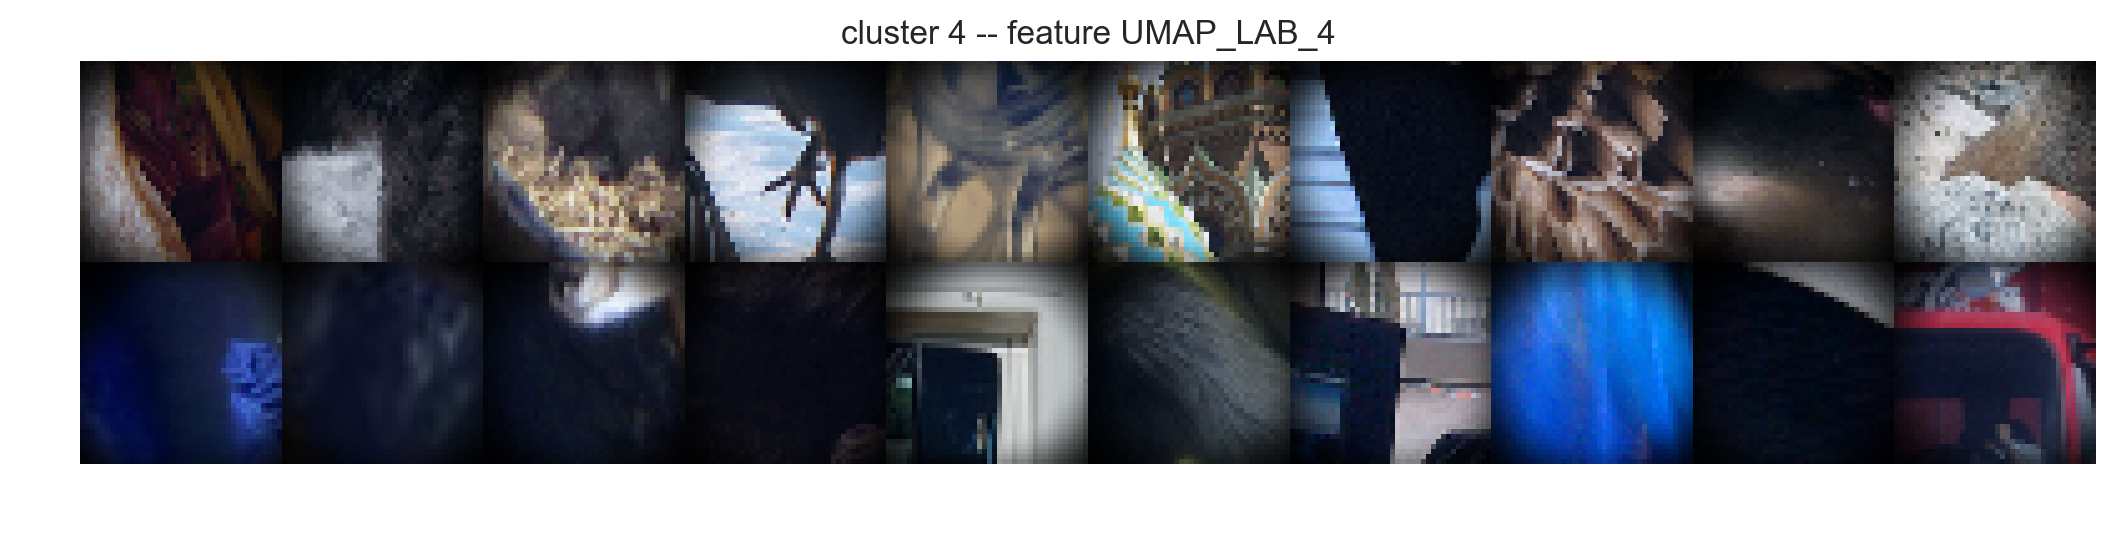

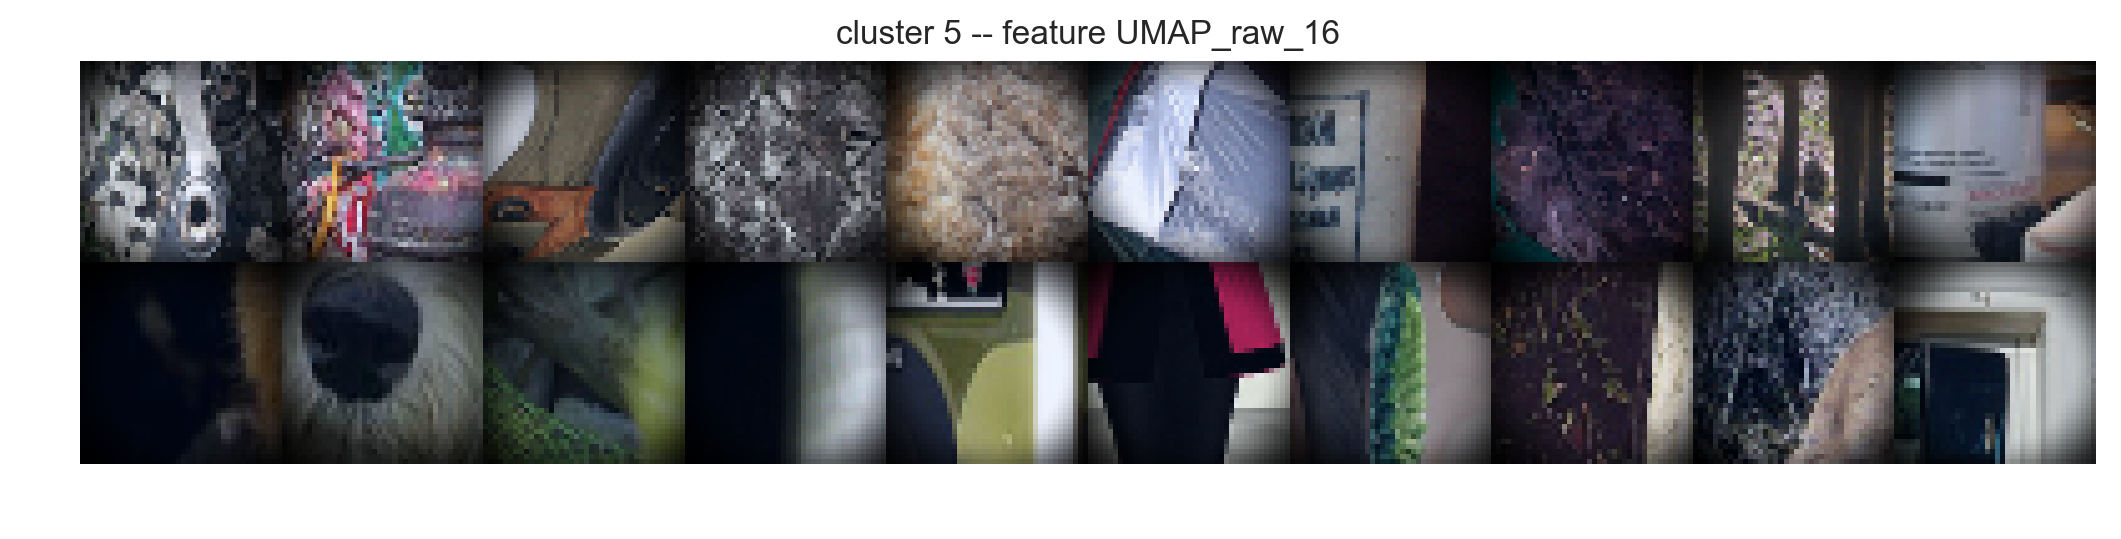

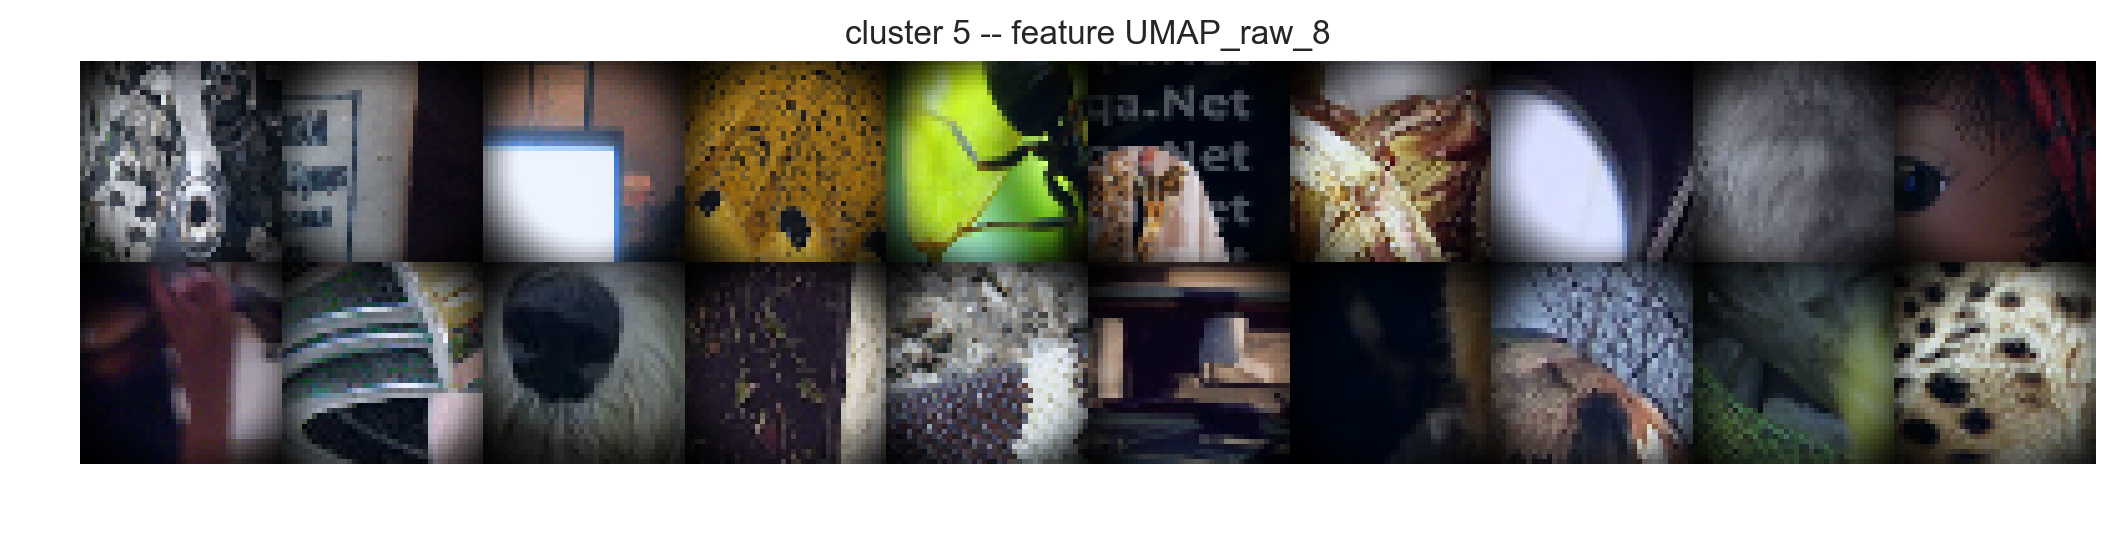

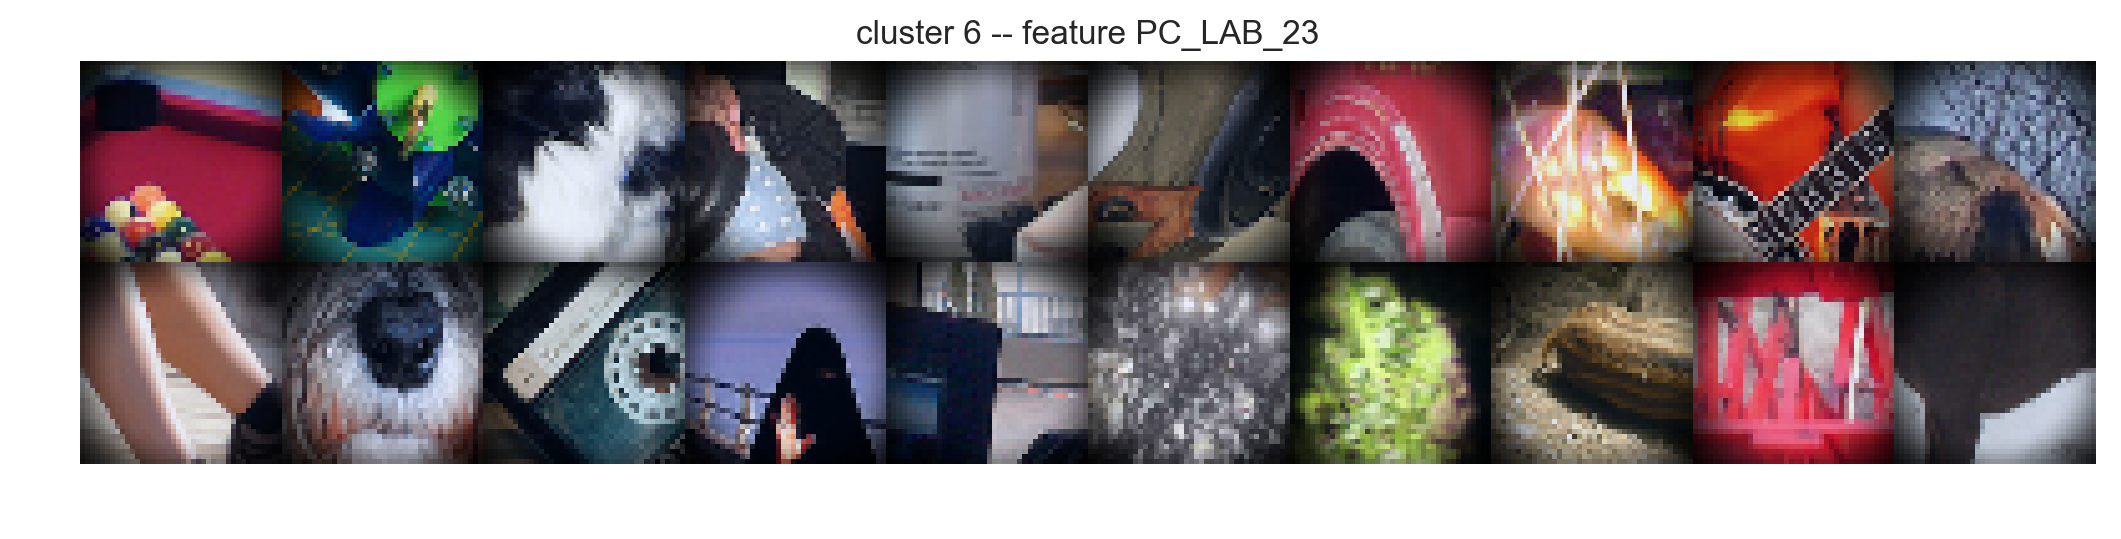

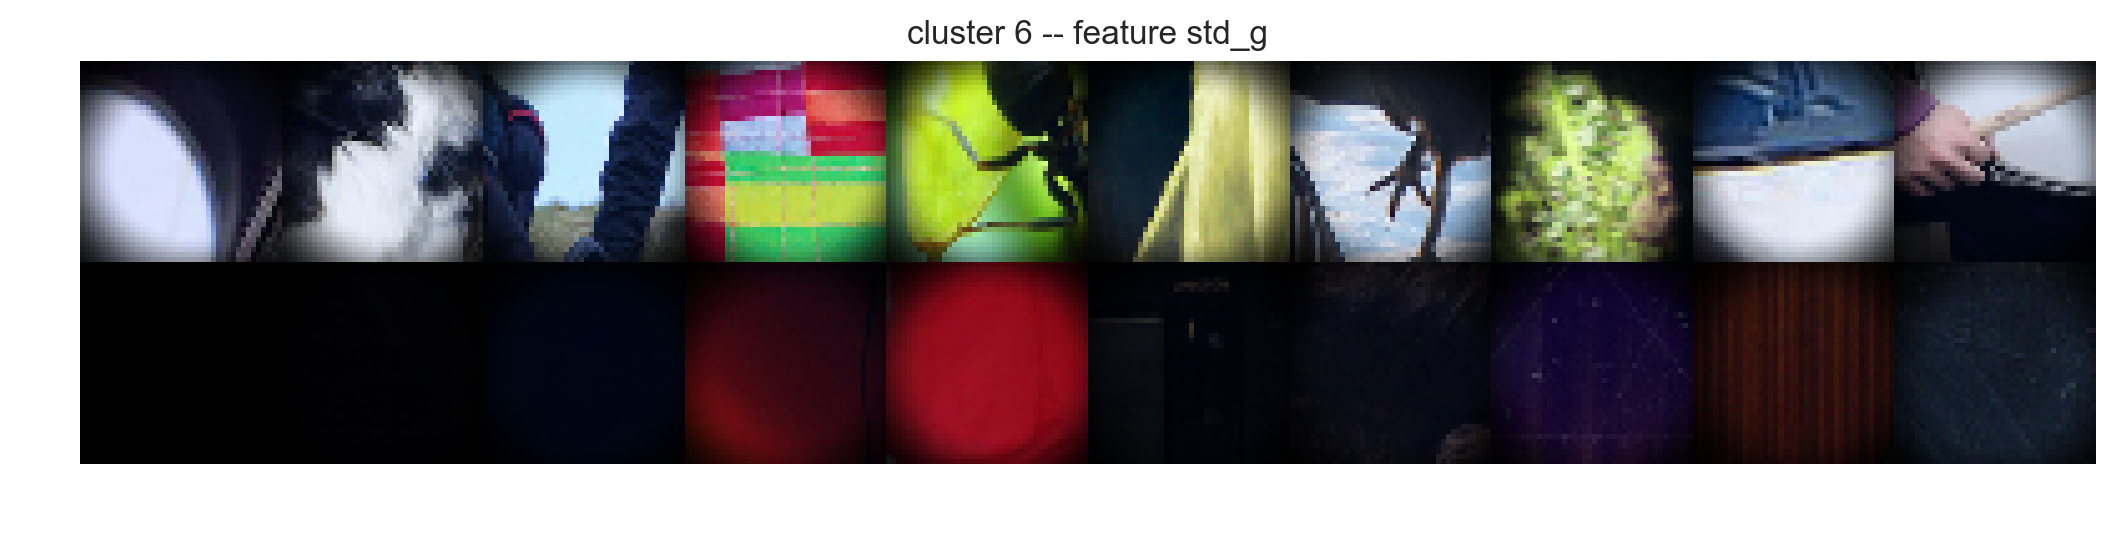

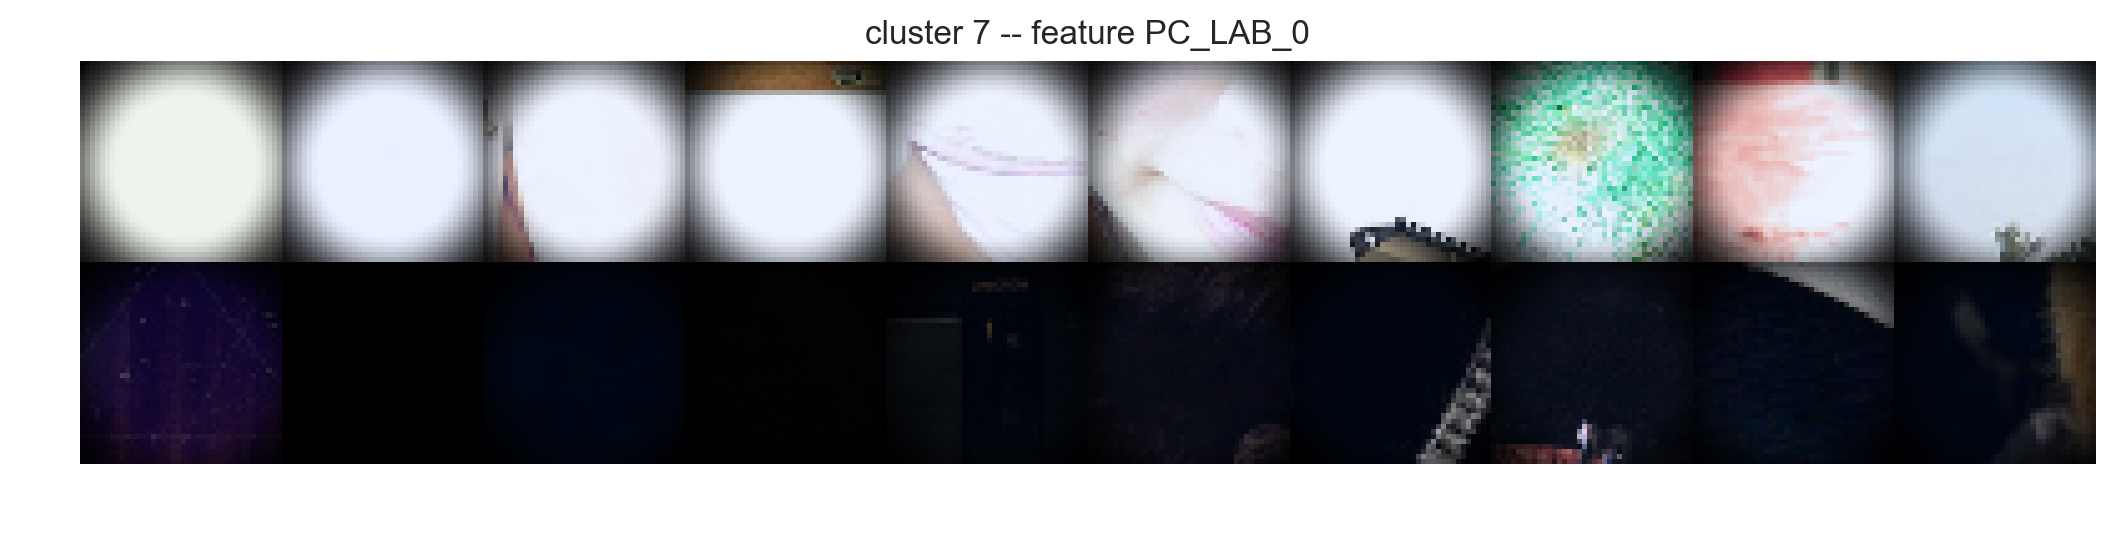

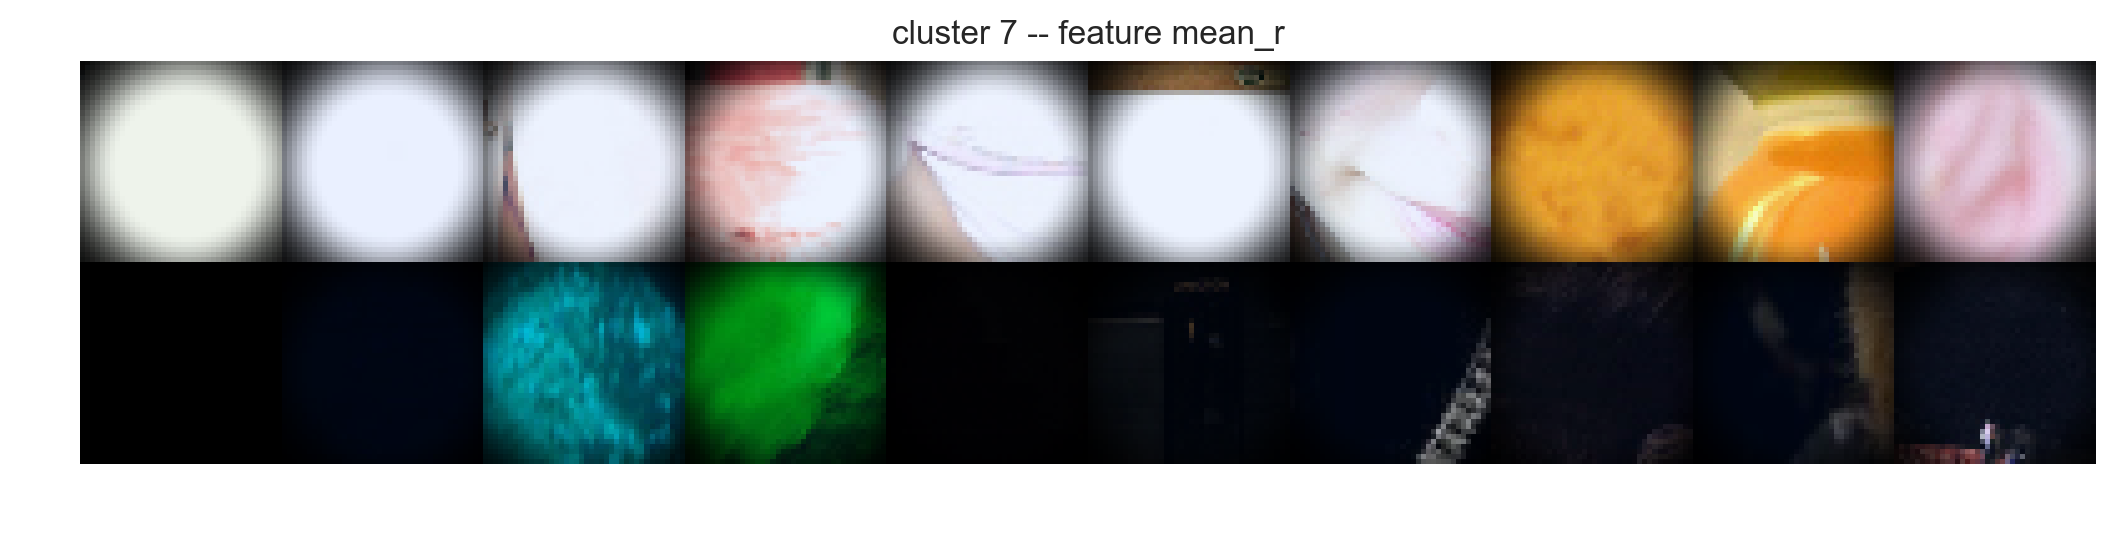

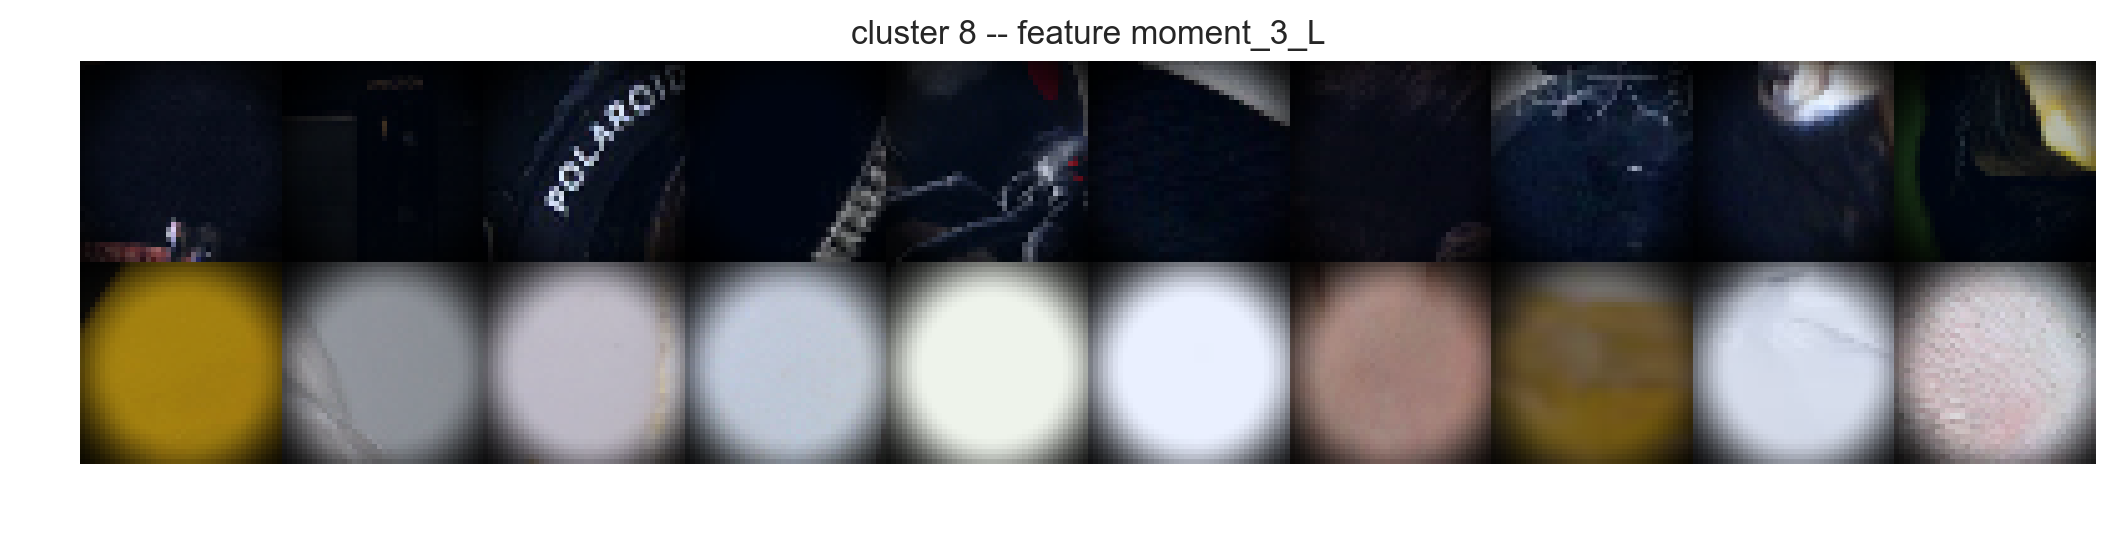

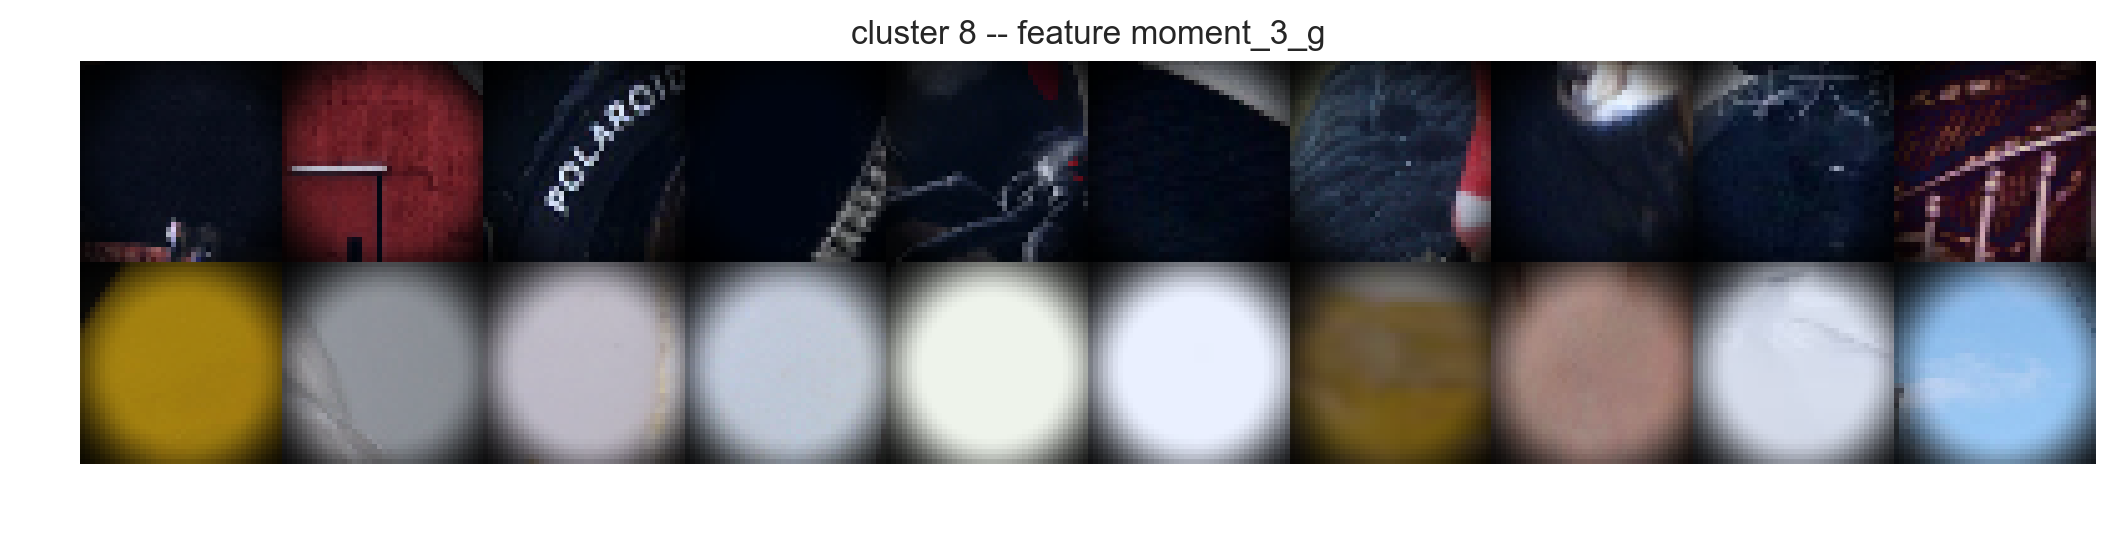

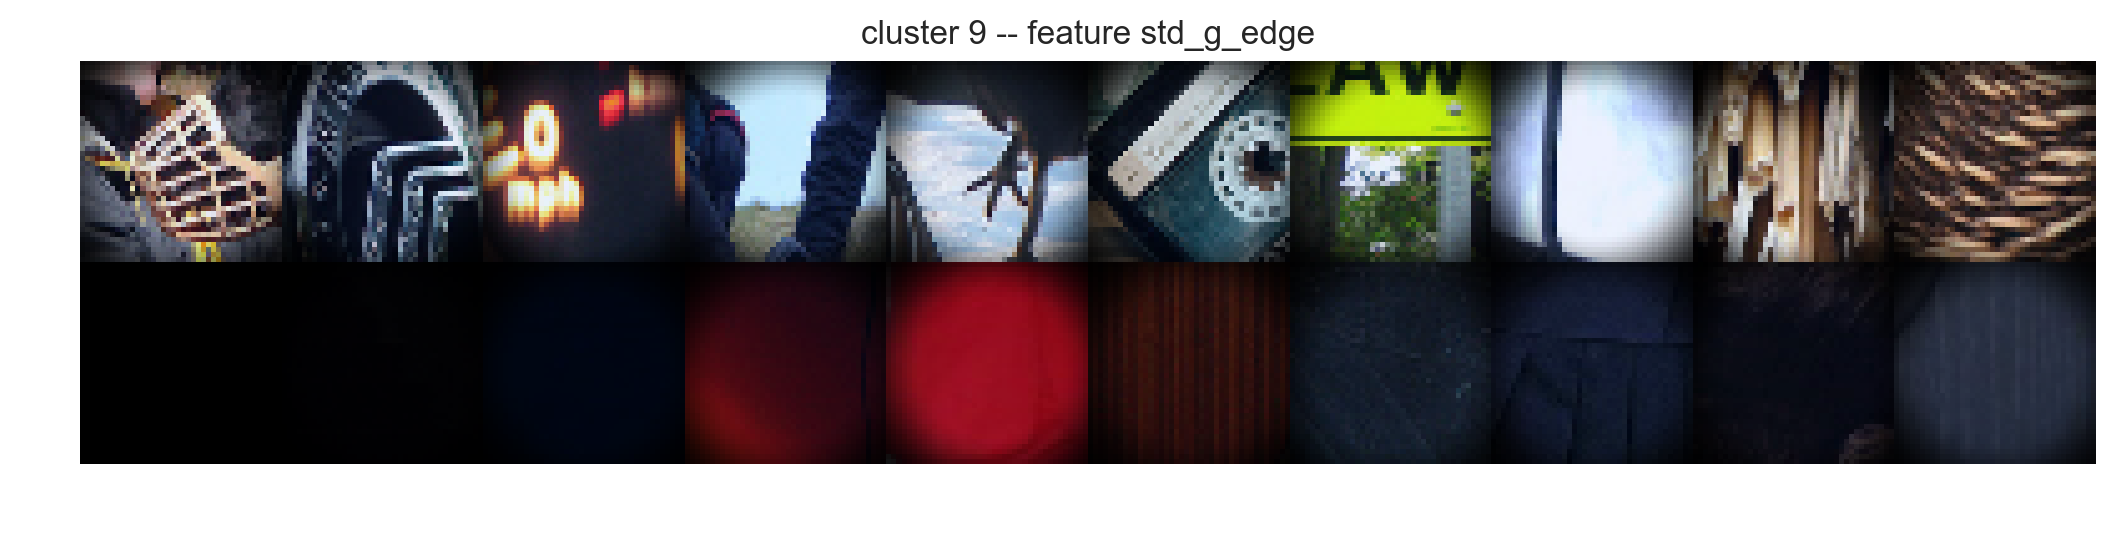

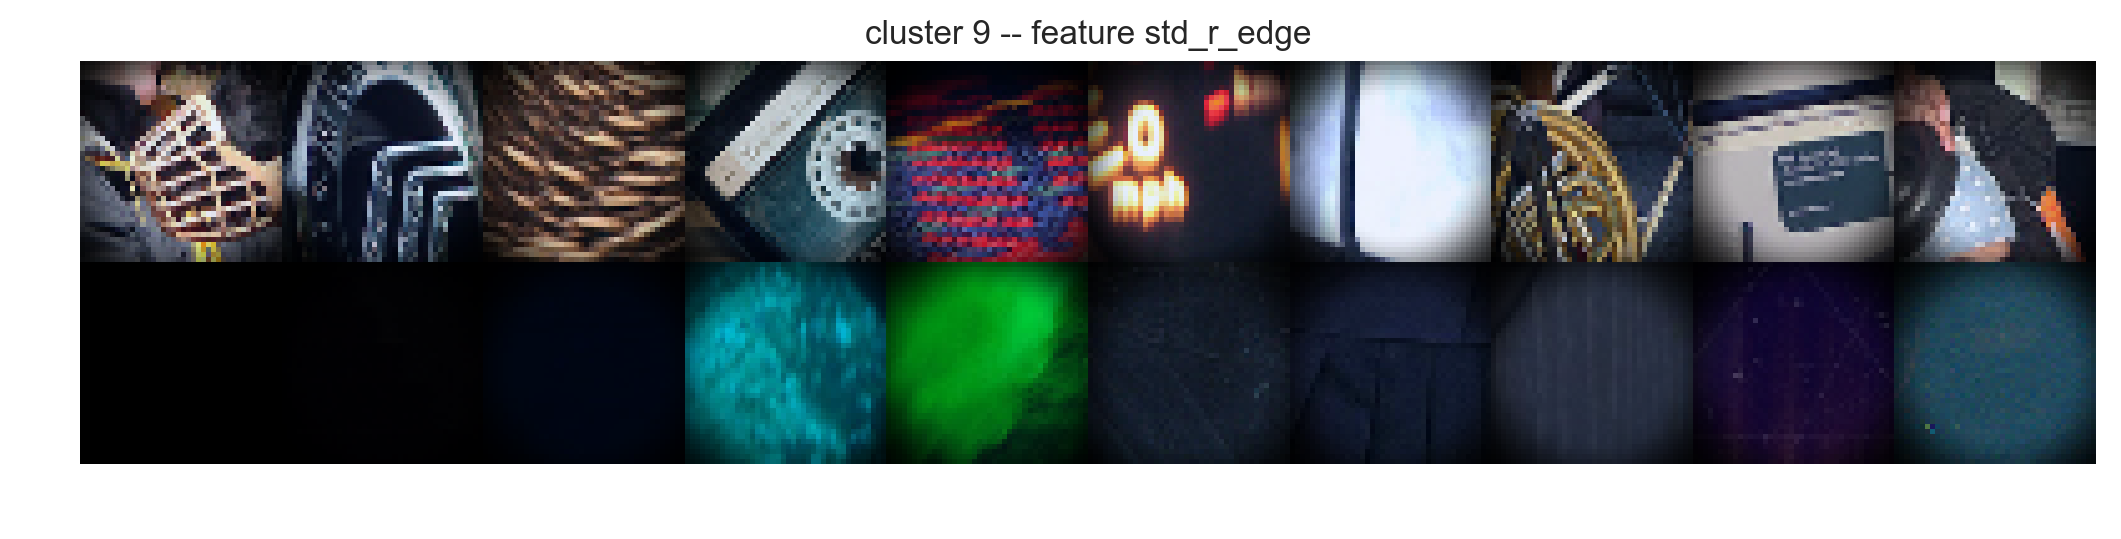

In [25]:
for c in np.unique(clusters):
    check = clusters == c
    summed = np.sum(importances[check,:], axis=0)
    ixs = np.argsort(-summed)[:2]

    for ix in ixs:
        vals = X_all[:, ix]
        figure()
        visualize_feature_maxmin(images, vals)
        title('cluster {} -- feature {}'.format(c, names[ix]))

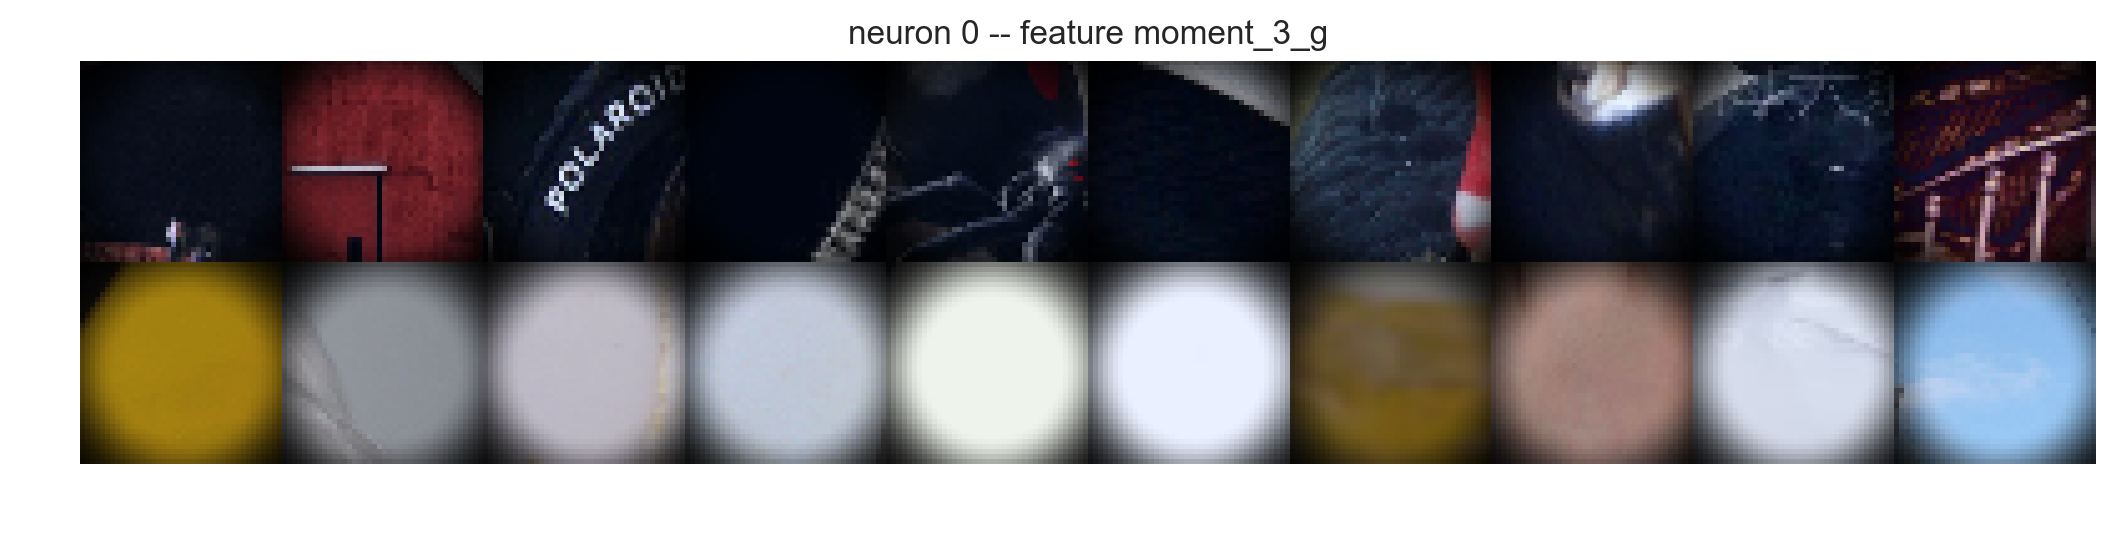

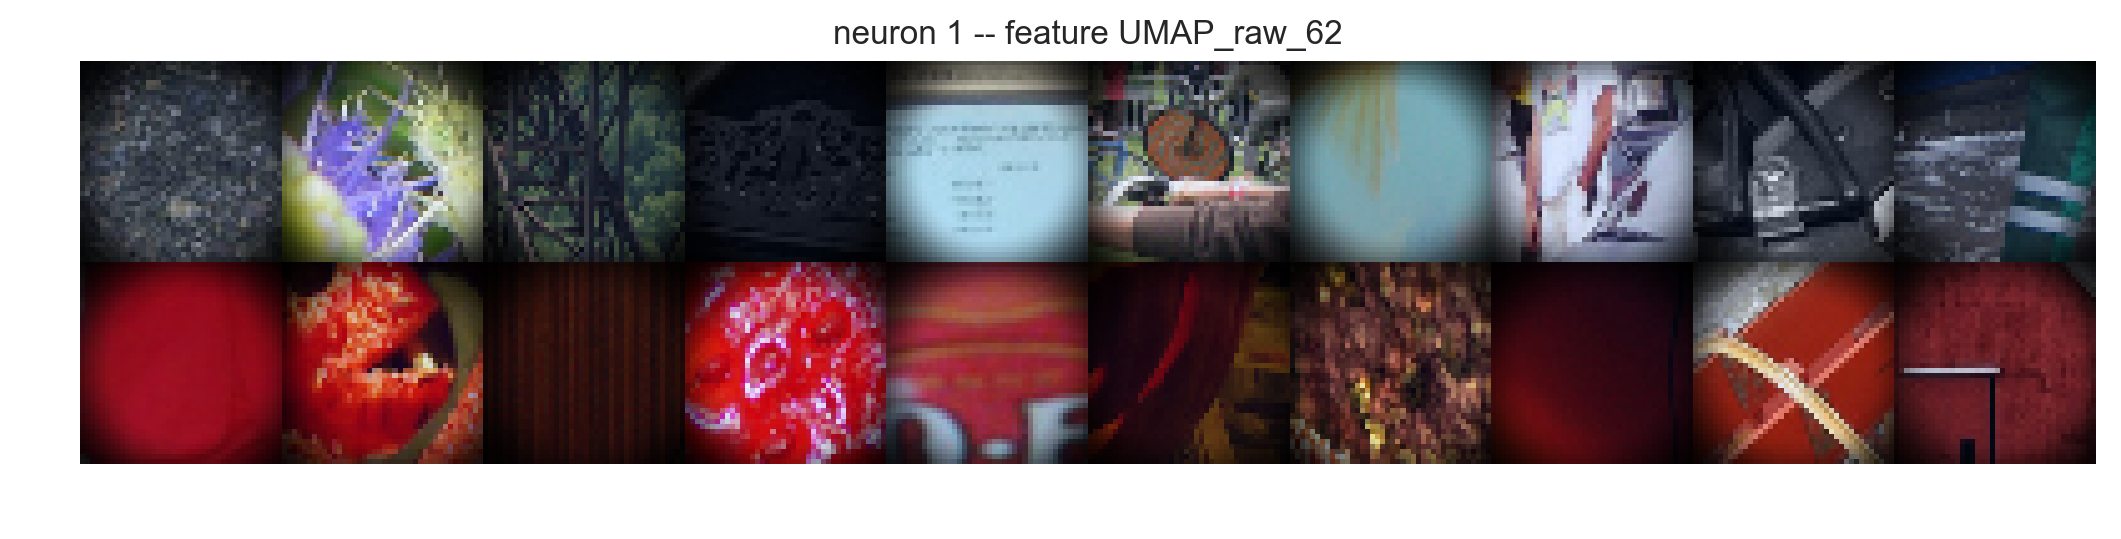

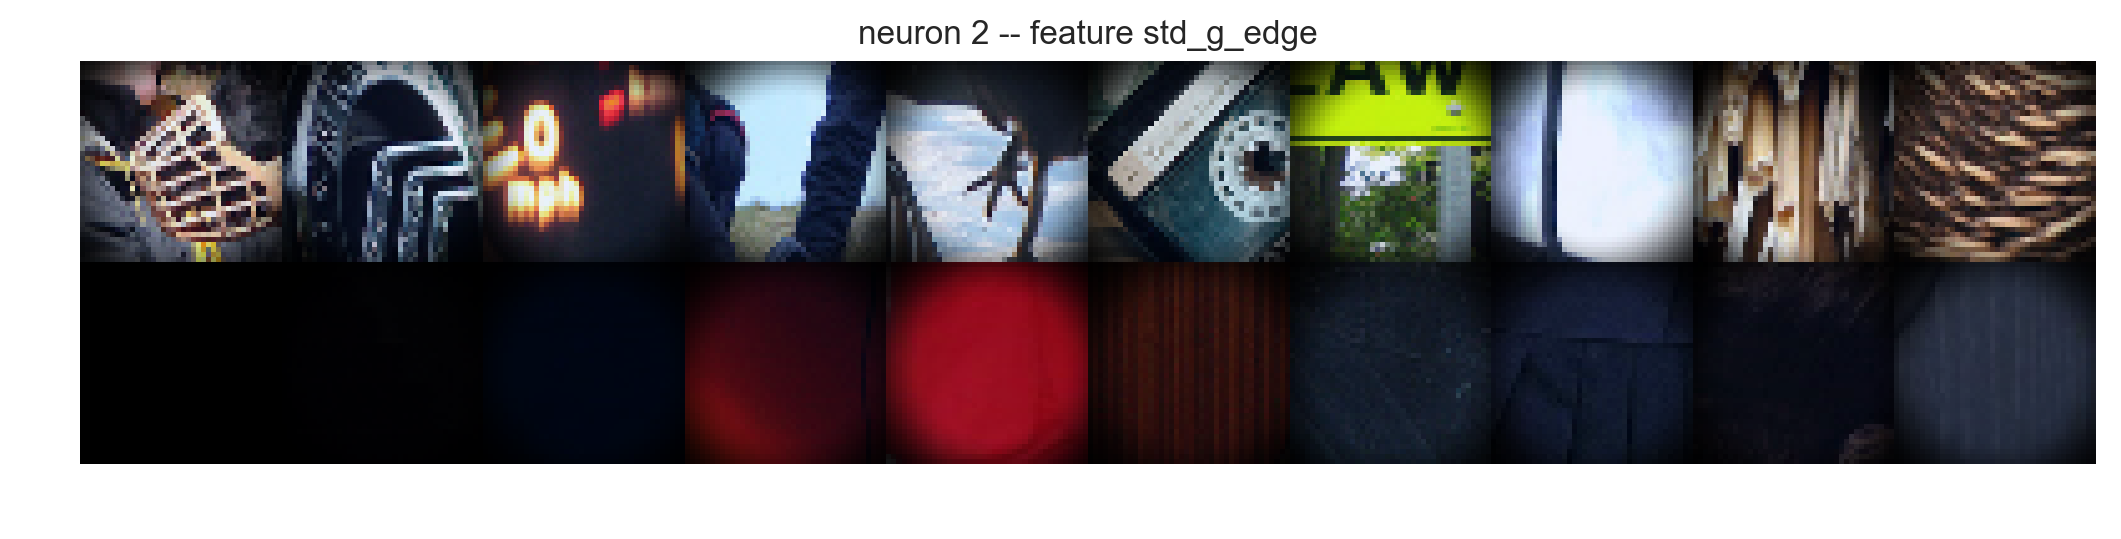

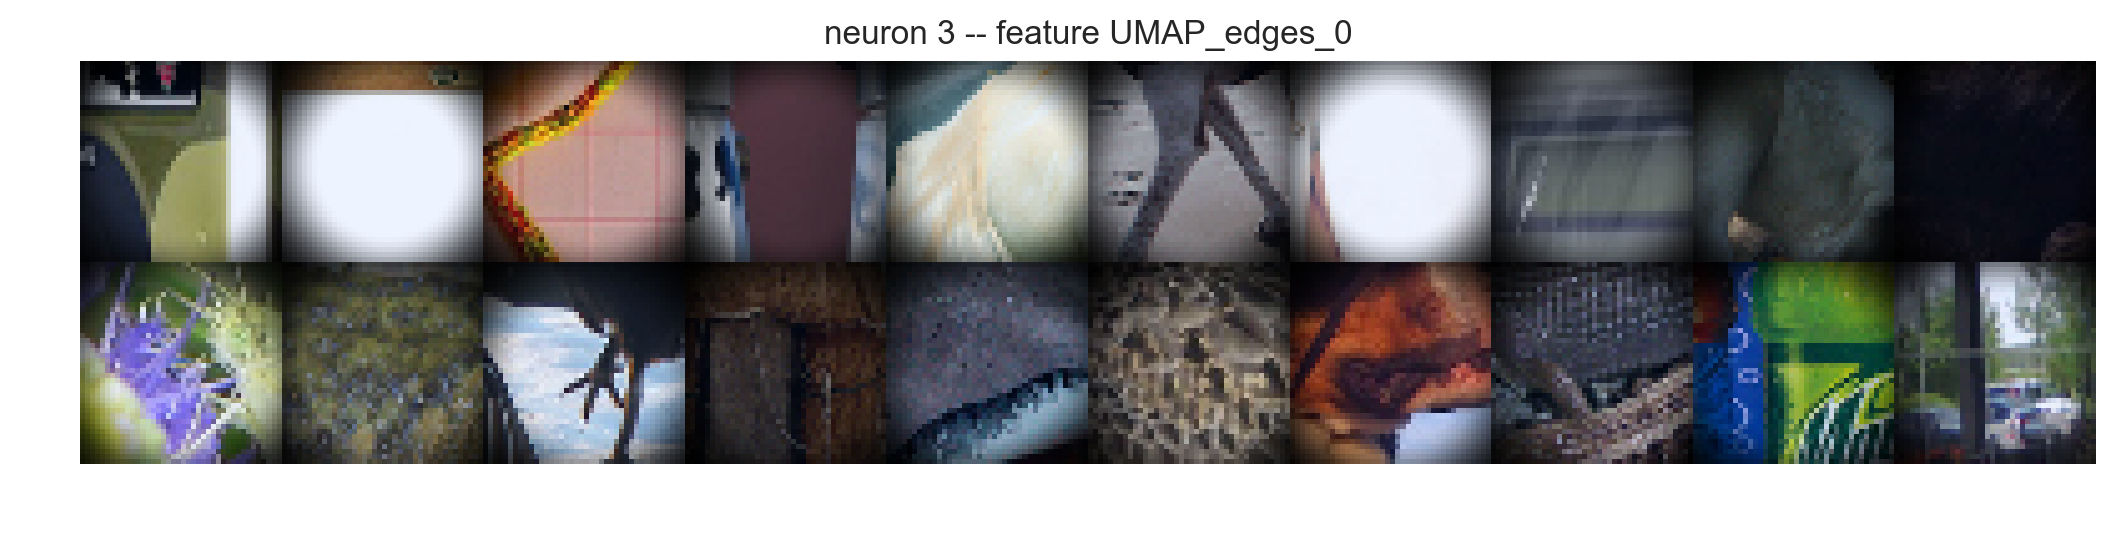

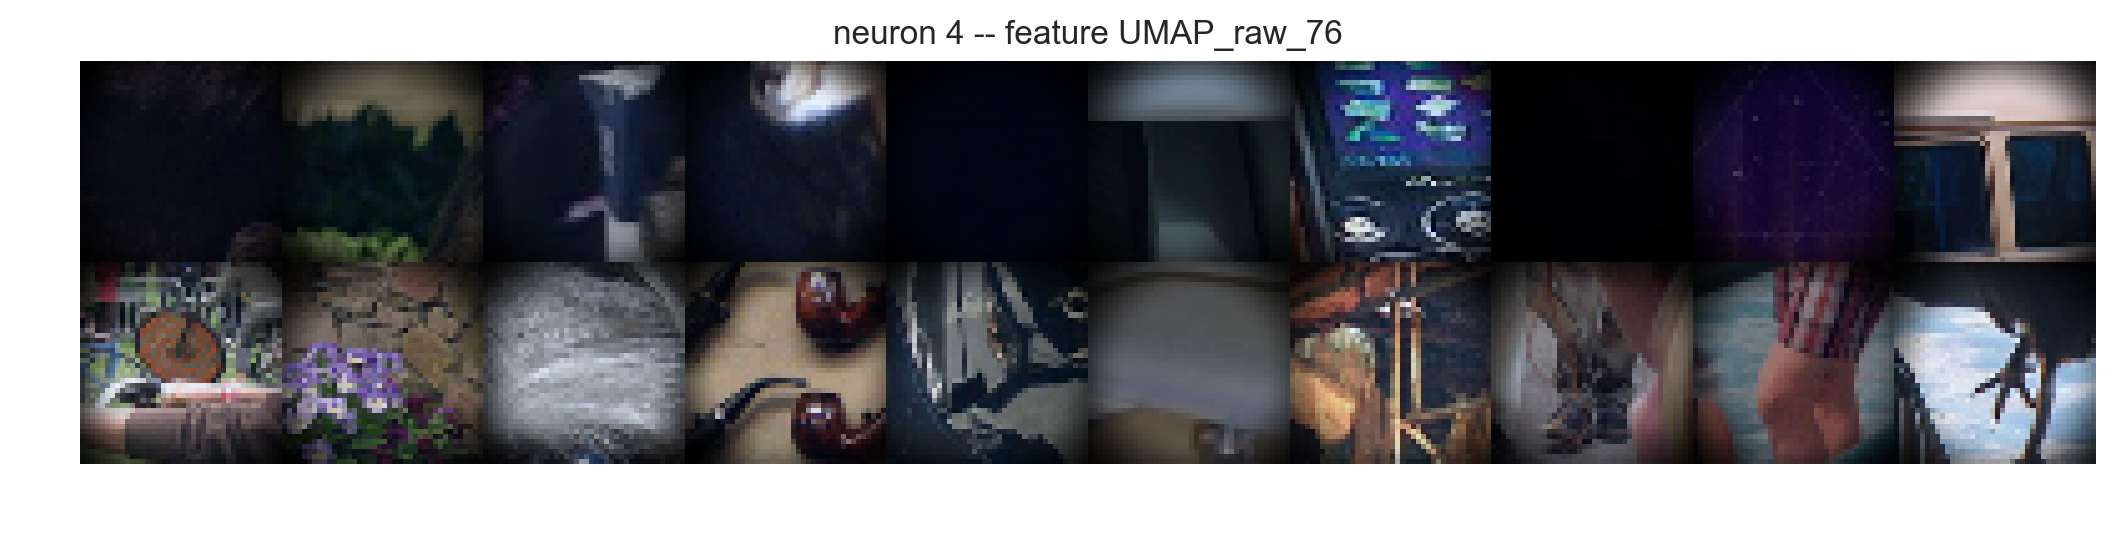

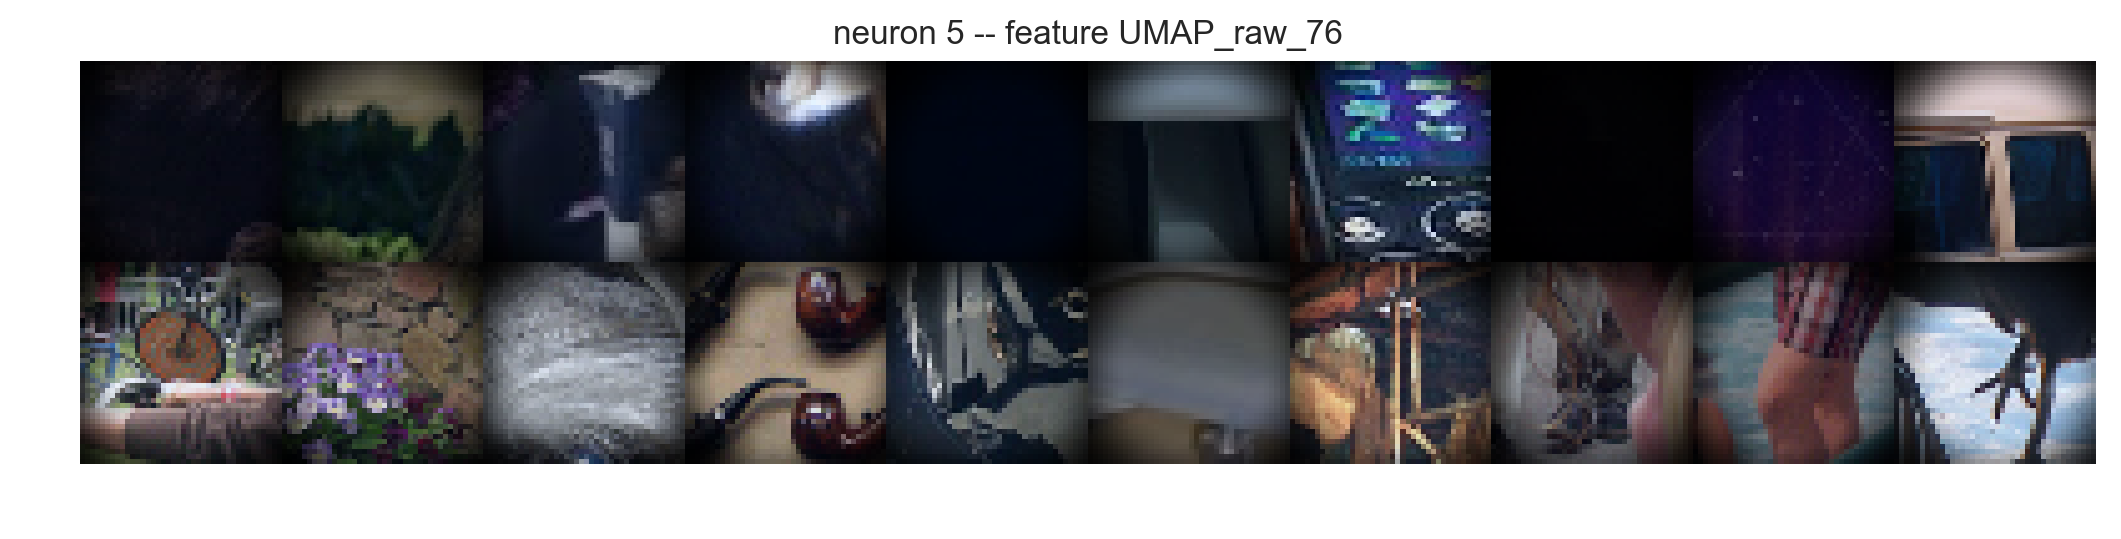

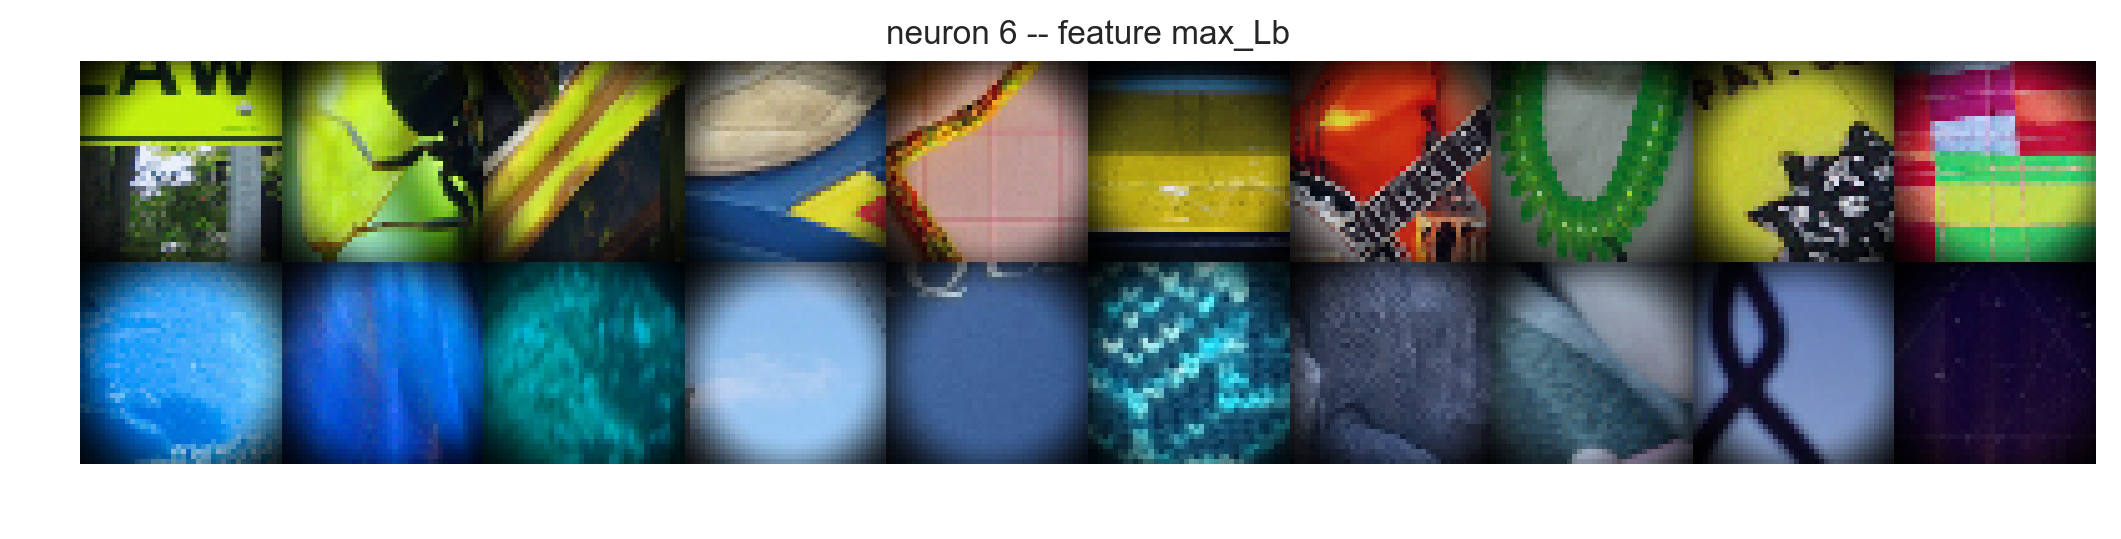

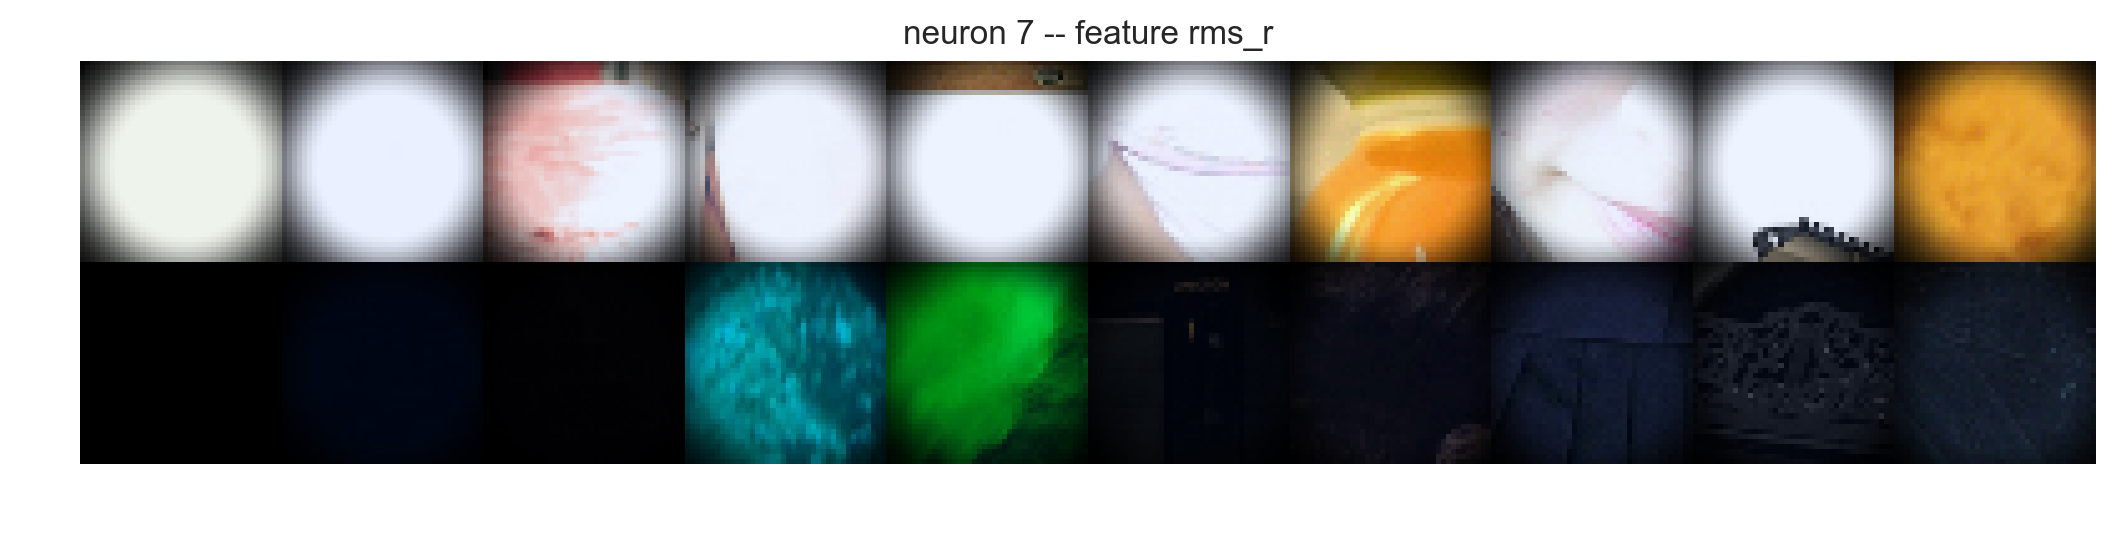

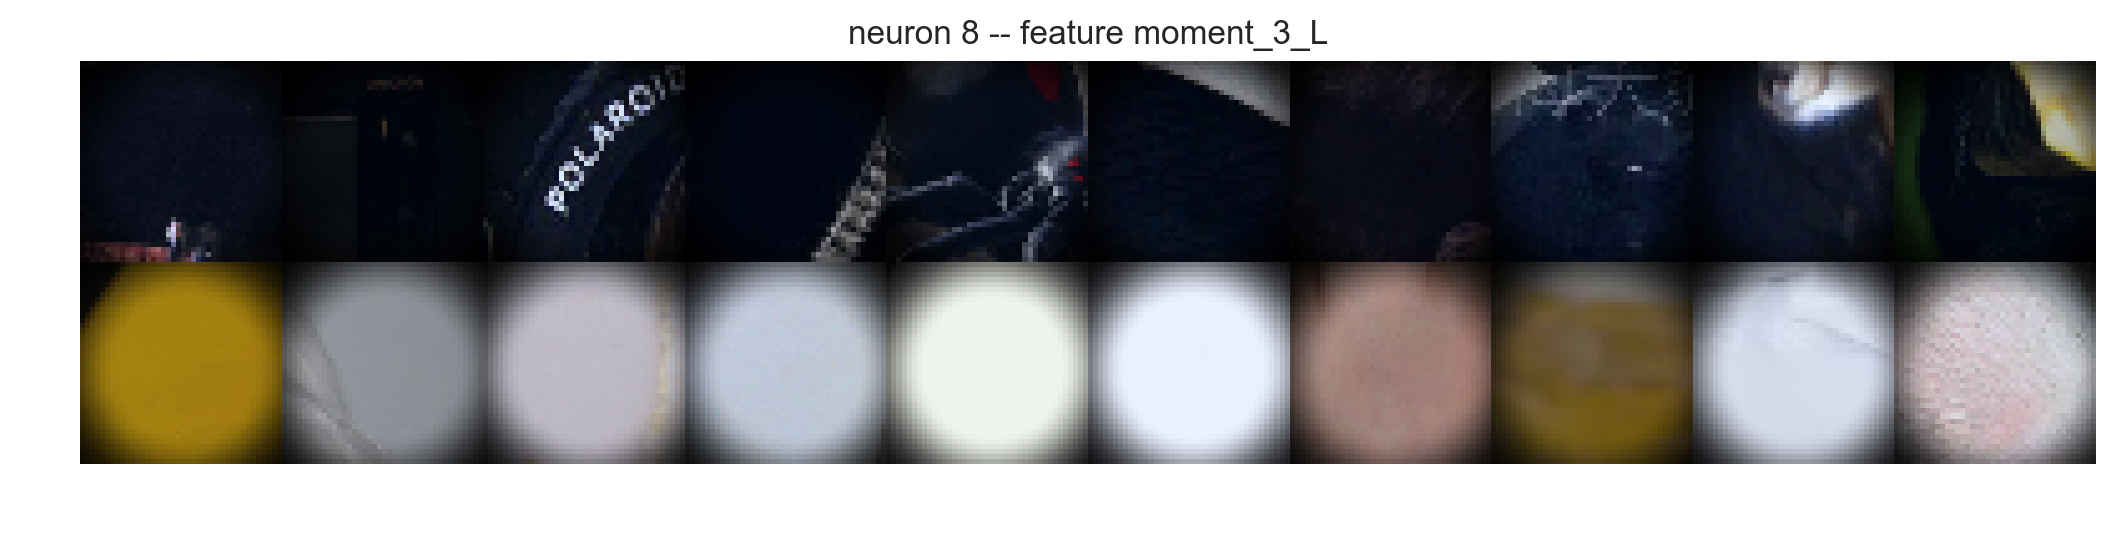

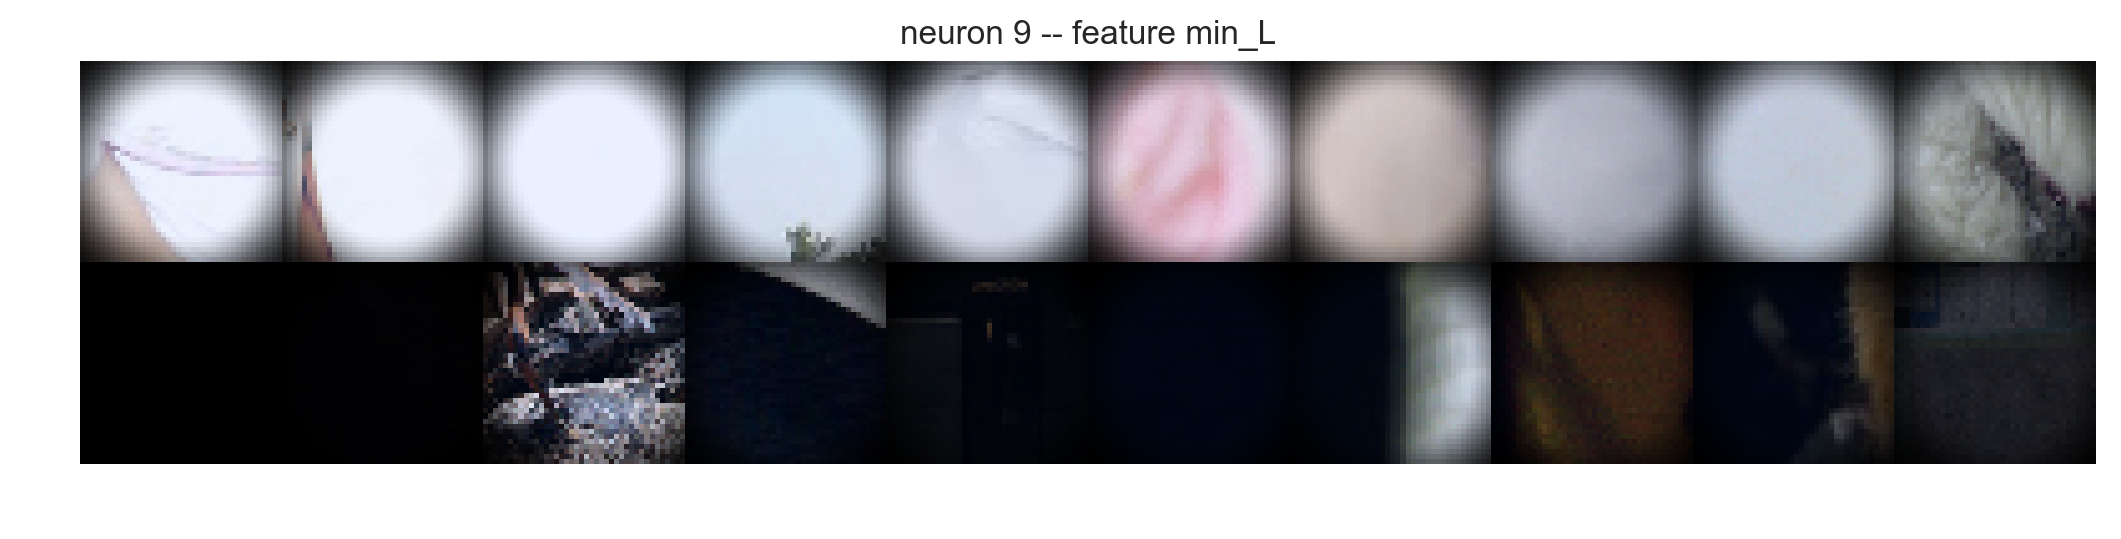

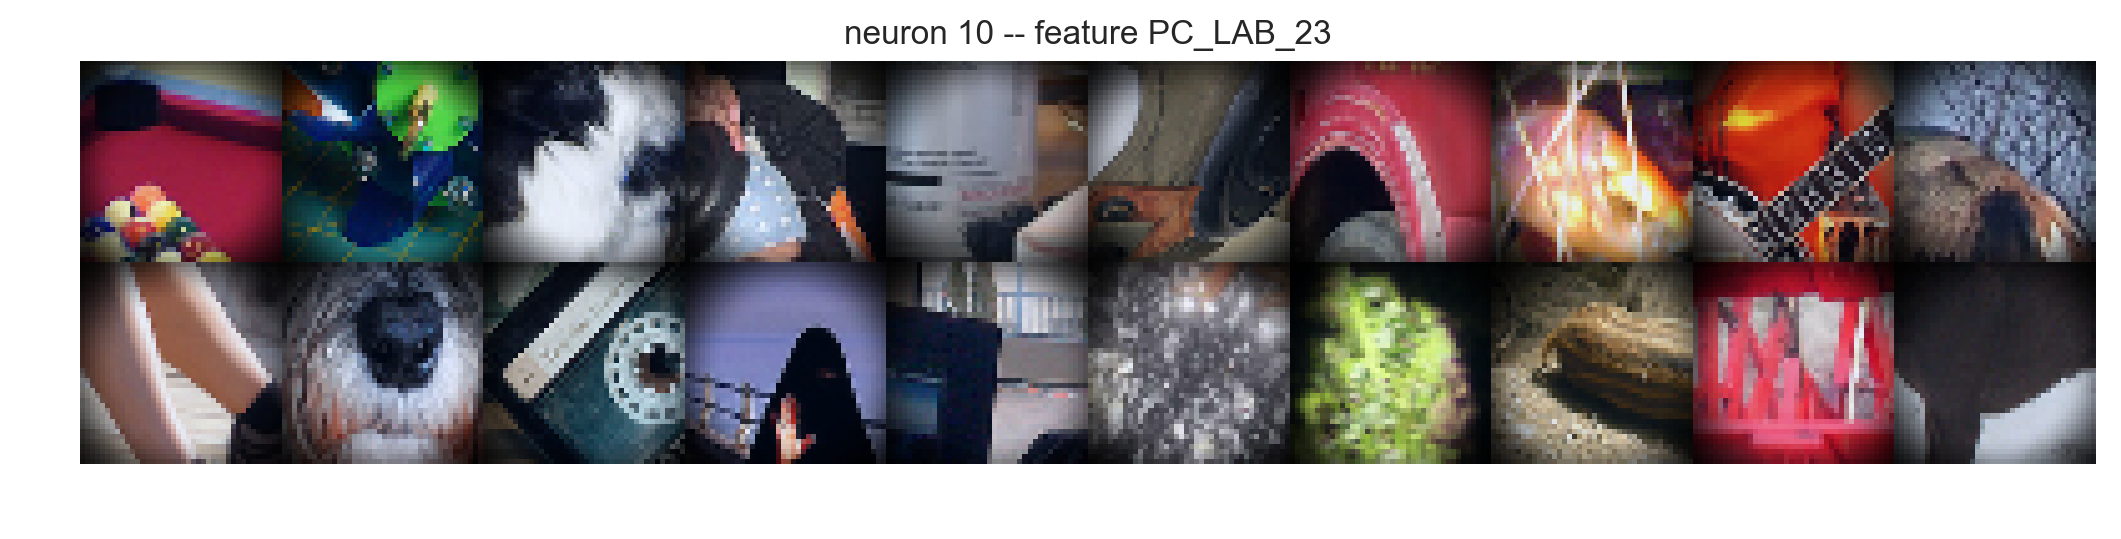

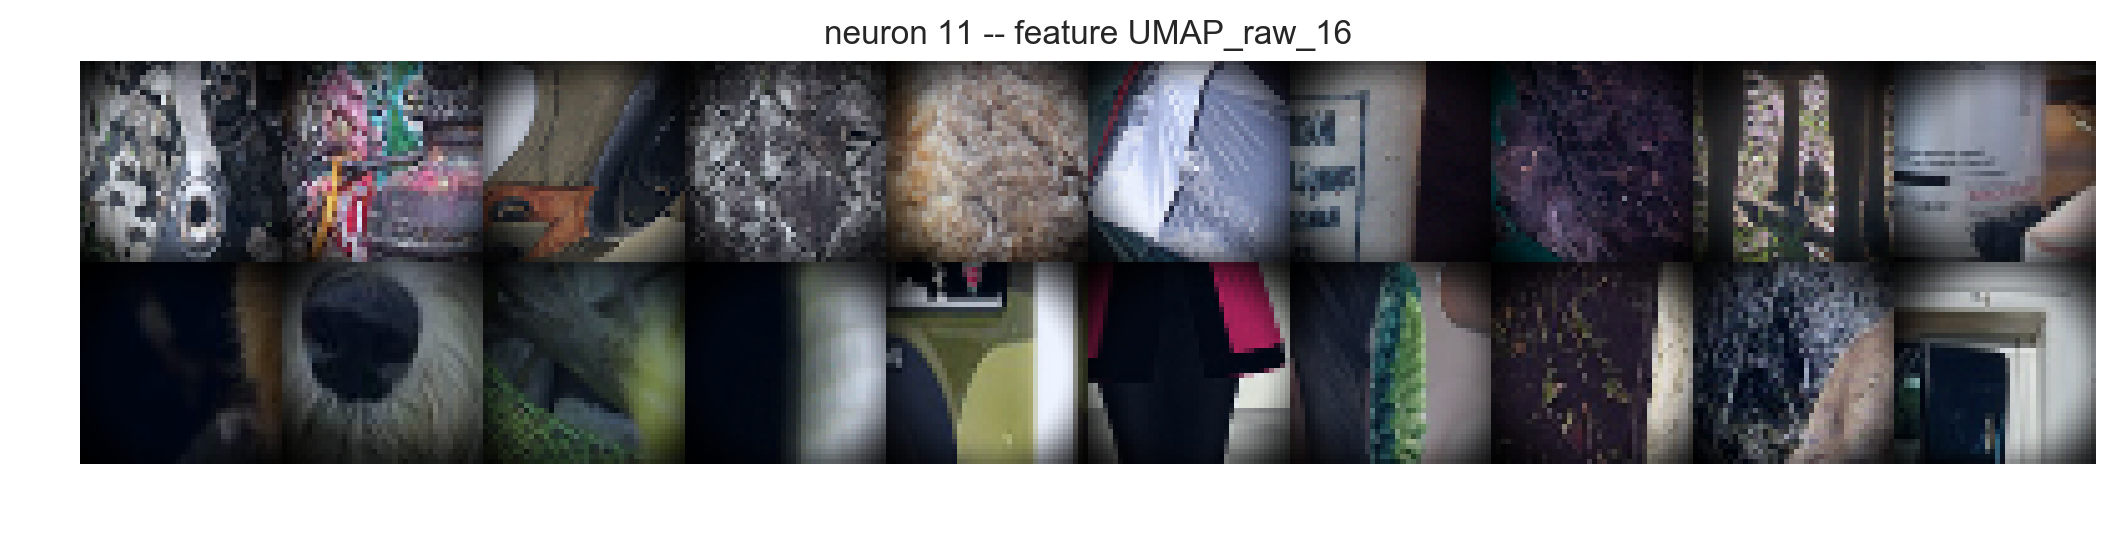

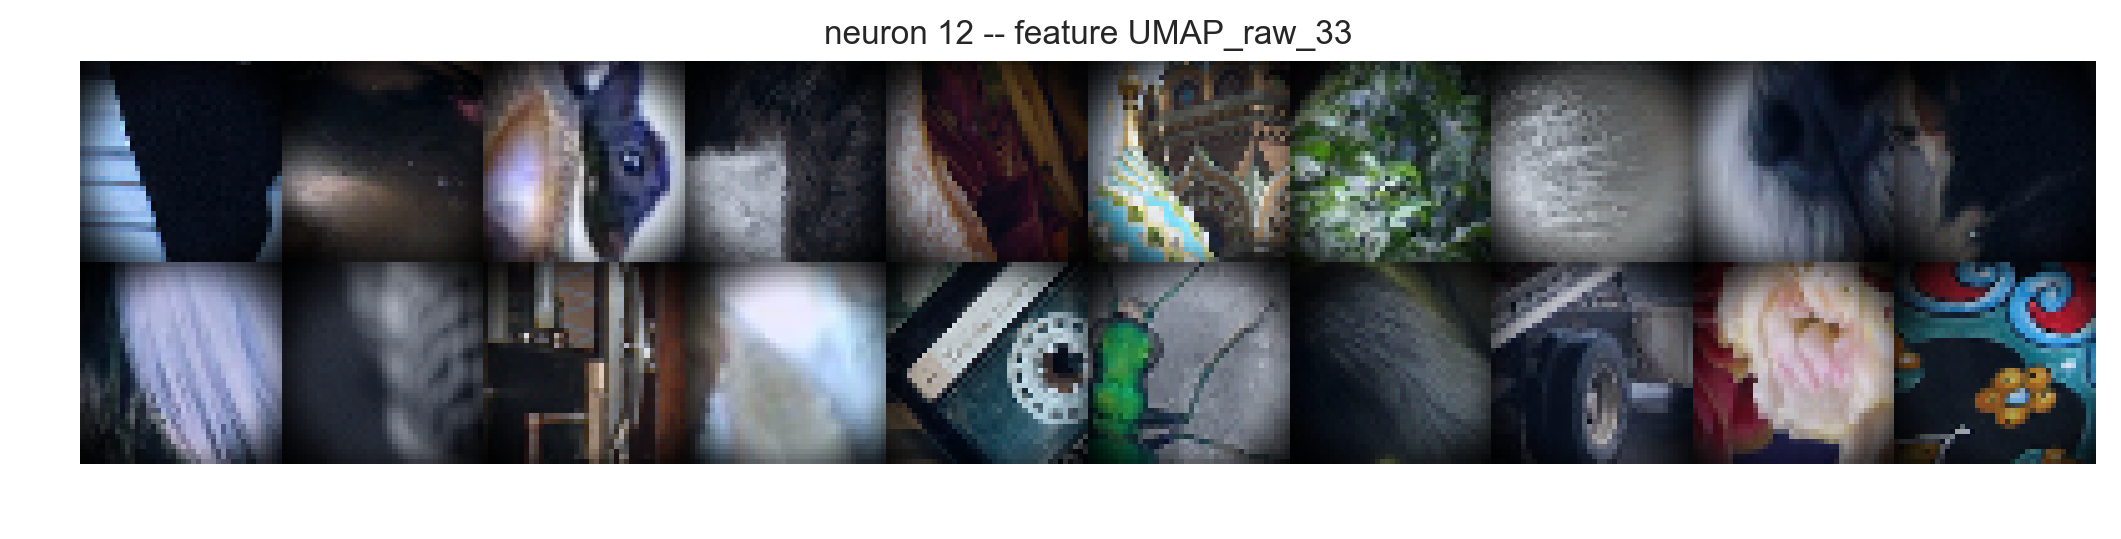

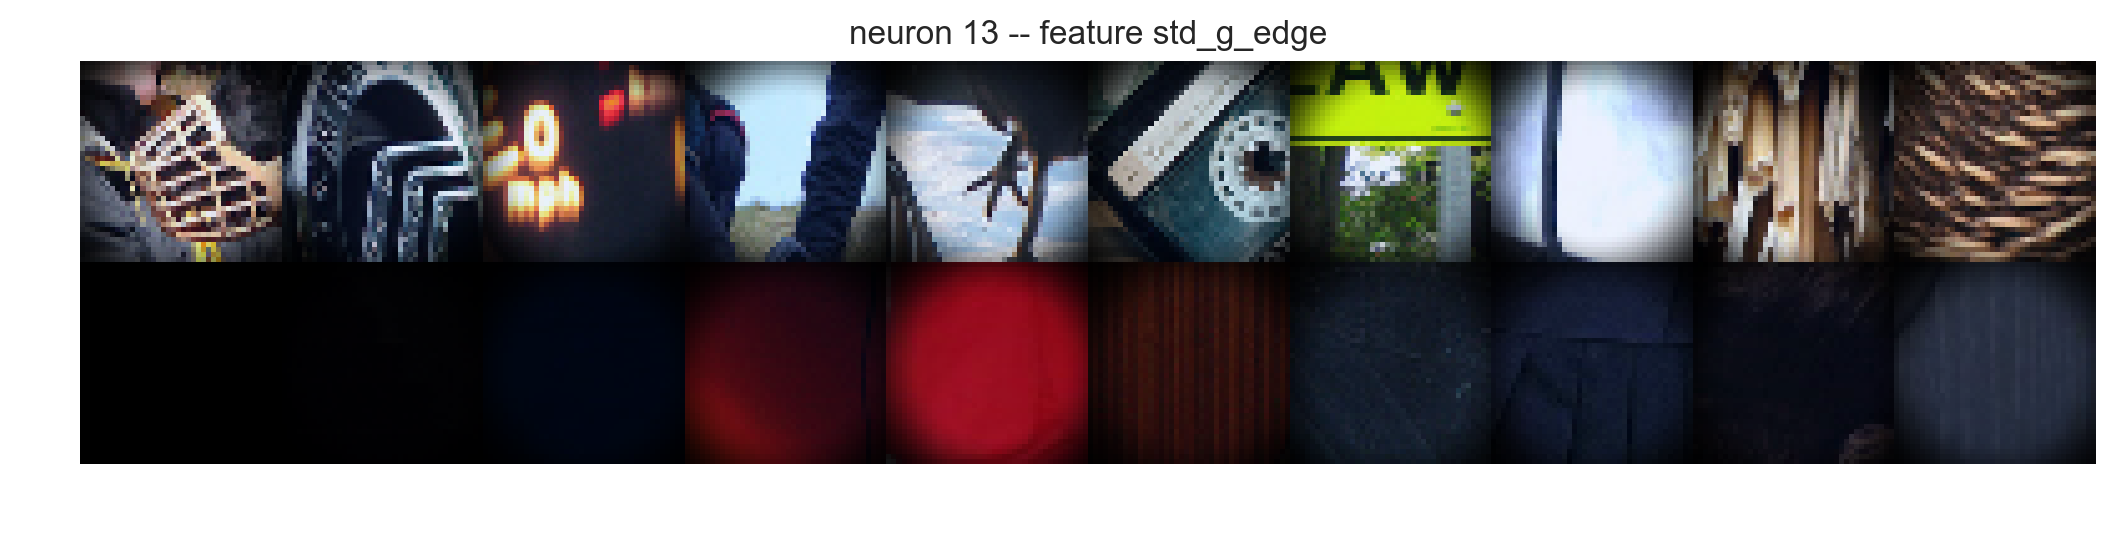

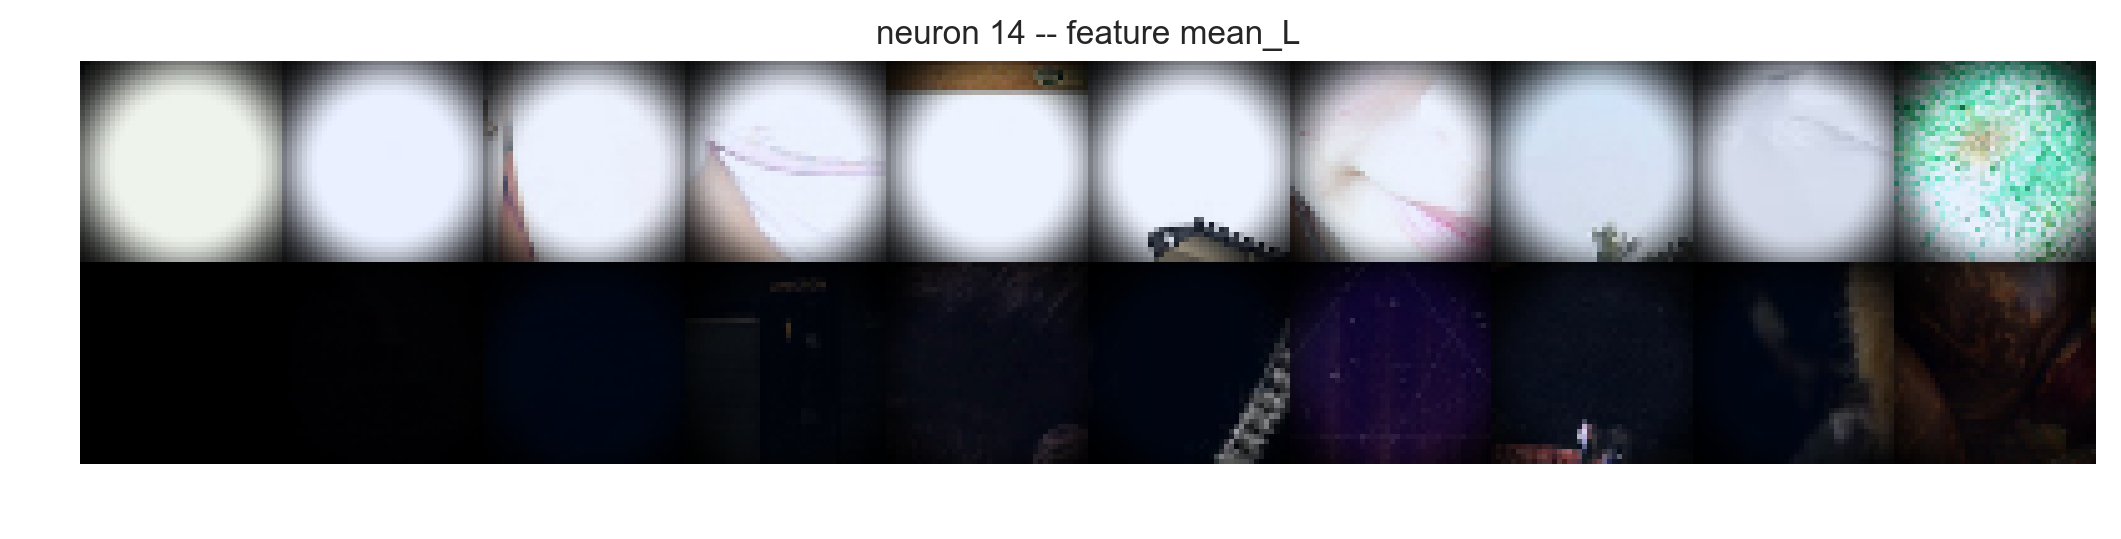

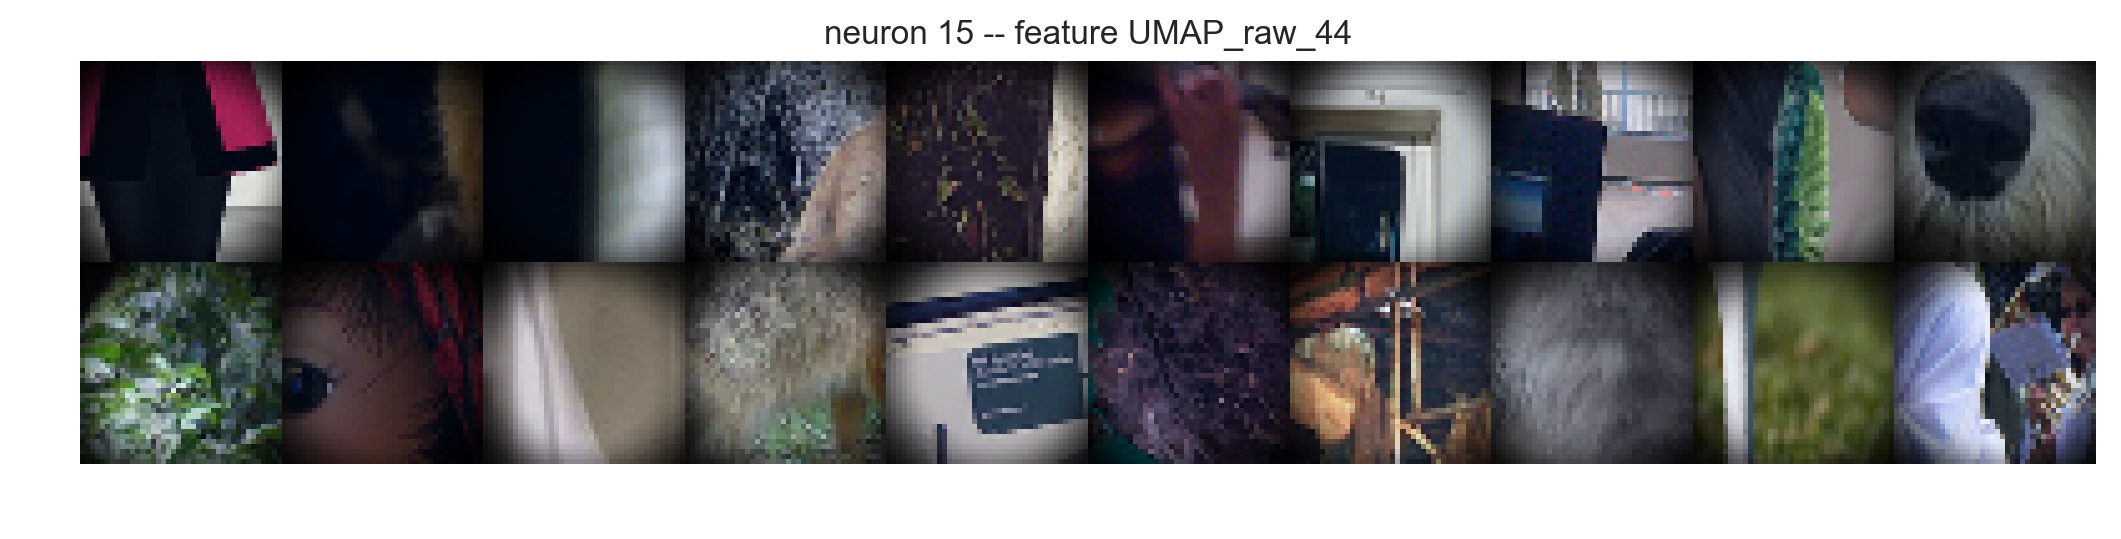

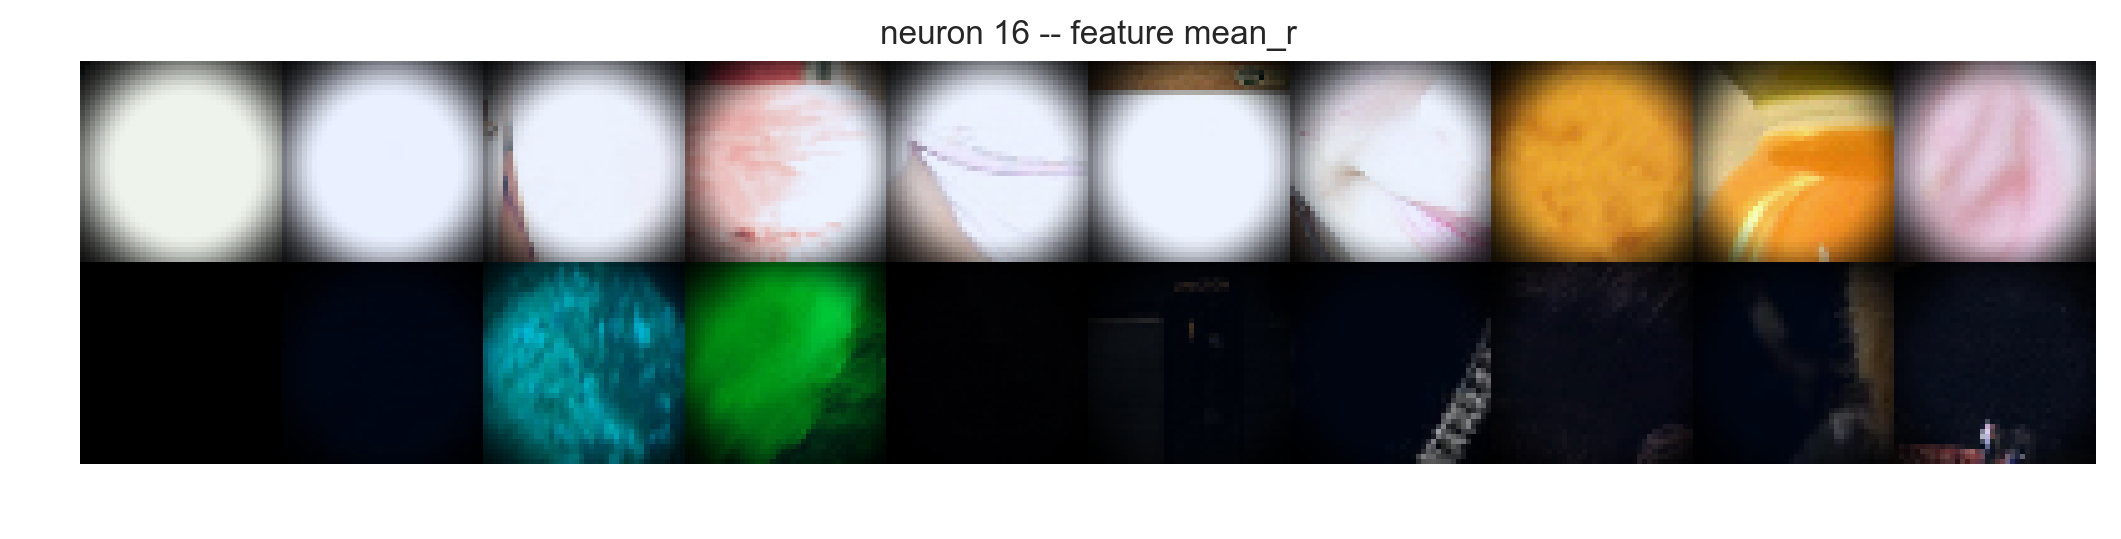

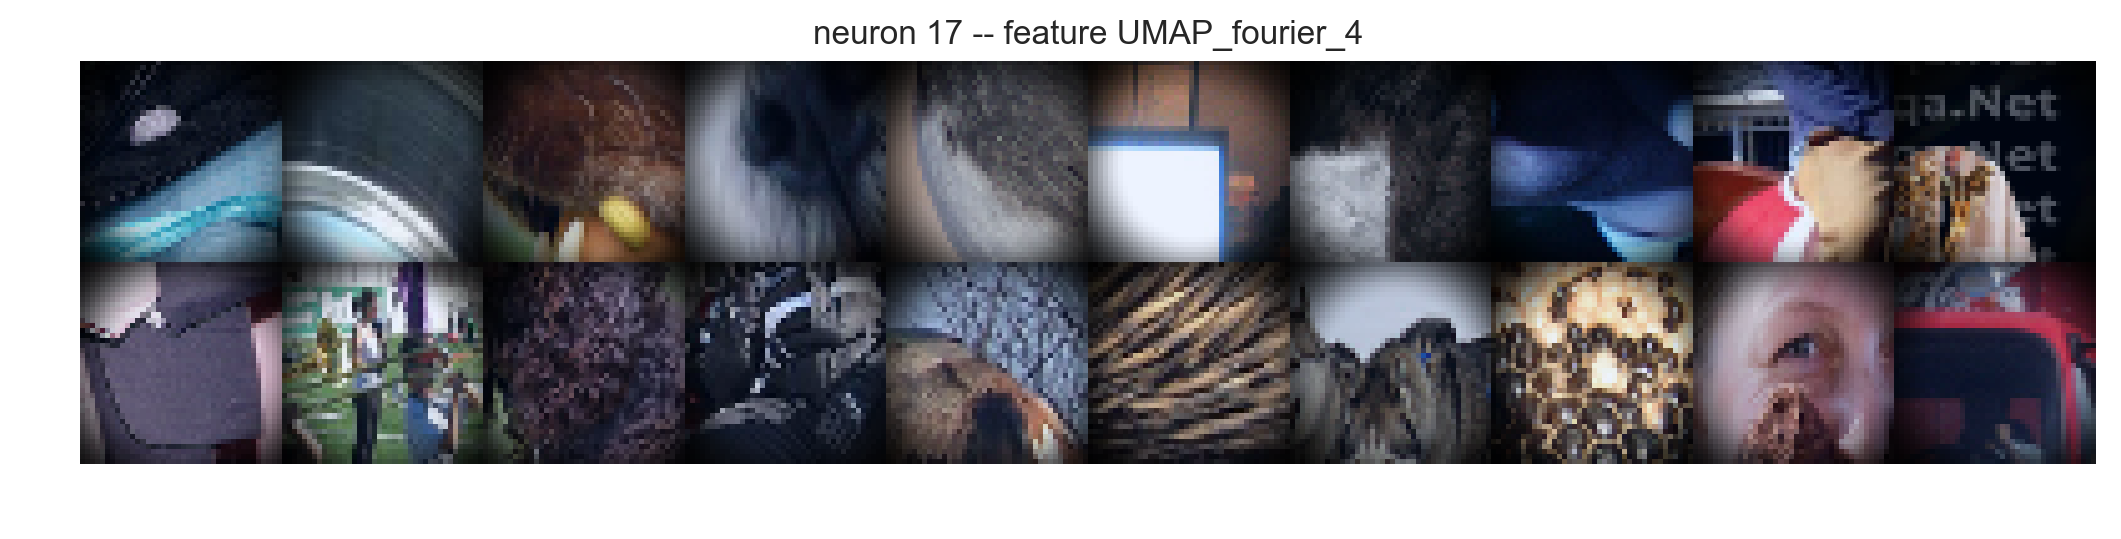

In [27]:
for i in range(importances.shape[0]):
    ixs = np.argsort(-importances[i])[:1]

    for ix in ixs:
        vals = X_all[:, ix]
        figure()
        visualize_feature_maxmin(images, vals)
        title('neuron {} -- feature {}'.format(i, names[ix]))